 <center>



 # **📘 Patent Classification - Task 2**



 ## *BERT Fine-tuning and Data Augmentation Strategies*



 </center>

 Building on the previous experiments with traditional feature-based methods (e.g., TF-IDF + Logistic Regression), which showed strong performance given their simplicity, we now turn to contextual language models—specifically BERT. While TF-IDF proved effective for structured patent text, it lacks the capacity to model word meaning in context. BERT, by contrast, is designed to capture rich semantic and syntactic dependencies, which may be especially valuable for domain-specific and complex texts like patents.



 ### **Outline**

 ---



 1. [🤖 BERT Model with Limited Data (32 examples)](#bert-limited-data)

 2. [🧪 Dataset Augmentation (No LLMs)](#dataset-augmentation)

 3. [🧠 Zero-Shot Learning with LLM](#zero-shot-llm)

 4. [📝 Data Generation with LLM](#data-generation-llm)

 5. [🚀 Optimal Technique Application](#optimal-technique)

In [1]:
# For Google collab the following need to be run:
!pip install evaluate
!pip install transformers-interpret
!pip install mistralai
!pip install datasets -U
!pip install setfit
!pip install lime

In [107]:
# Essential imports and setup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average="macro"):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average, zero_division=0)
        recall = recall_score(y_true, y_pred, average=average, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=average, zero_division=0)

        # Store results
        self.results[method_name] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    def plot(self, custom_palette=None):
        # Default color palette
        methods = list(self.results.keys())
        if custom_palette is None:
            custom_palette = sns.color_palette("Spectral", n_colors=len(methods))

        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        metric_names = ["Accuracy", "Precision", "Recall", "F1"]

        for i, metric in enumerate(metric_names):
            ax = axs[i // 2, i % 2]
            values = [self.results[m][metric.lower()] * 100 for m in methods]

            # Plot bars
            ax.bar(methods, values, color=custom_palette)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Annotate bars
            for j, v in enumerate(values):
                ax.text(j, v + 1, f"{v:.2f}", ha="center", va="bottom")

            # Rotate x-axis labels
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels(methods, rotation=25)

            # Style spines
            ax.spines["bottom"].set_color("black")
            ax.spines["left"].set_color("black")
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            # Style ticks
            ax.tick_params(axis="y", colors="black", direction="in", length=5, width=1)
            ax.tick_params(axis="x", colors="black", direction="in", length=5, width=1)

        plt.tight_layout()
        plt.show()


import os
import pickle
import random

import evaluate
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.metrics import confusion_matrix
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)
from transformers_interpret import SequenceClassificationExplainer

sns.set_style("darkgrid")
sns.set_palette("Spectral")

dataset = load_dataset("ccdv/patent-classification", "abstract")

 # **1. BERT Model with Limited Data**

 ---



 This section explores a **few-shot learning setup** where we fine-tune a pre-trained BERT model using only **32 labeled patent examples**.



 The goal is to assess how well BERT can generalize with minimal supervision by leveraging its strong language understanding from pretraining.



 **Why this matters for patent classification:**

 - Patent classification often faces data scarcity in emerging technology areas

 - Manual labeling of patents is expensive due to required domain expertise

 - Real-world scenarios often have <100 examples per new patent category

 - BERT's pretraining on general text may transfer well to patent language



 **Technical challenges:**

 - **Overfitting**: Large models (110M parameters) vs. tiny datasets (32 examples)

 - **Class imbalance**: Some patent categories are naturally rare

 - **Domain gap**: General pretraining vs. specialized patent vocabulary

 - **Evaluation noise**: Small test sets create high variance in metrics

In [108]:
model_ckpt = "FacebookAI/roberta-base"

num_labels = len(set(dataset["train"]["label"]))
max_length = 256 # Research shows, decisive patent information is often in the first bits of the patent text
batch_size = 64
seed = 42

CLASS_NAMES = {
    0: "Human Needs",
    1: "Operations & Transport",
    2: "Chemistry & Metallurgy",
    3: "Textiles & Paper",
    4: "Construction",
    5: "Mechanical & Thermal Engineering",
    6: "Physics",
    7: "Electricity",
    8: "Cross-Tech Tagging",
}


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(seed)

## **Why RoBERTa for Patent Classification**

We chose RoBERTa over BERT for several technical advantages:

- **Improved pretraining**: Removes Next Sentence Prediction task which hurts single-document classification like patents
- **Dynamic masking**: Tokens masked differently each epoch vs. BERT's static masking, providing more training signal diversity
- **Better tokenization**: Byte-level BPE handles technical patent terminology more effectively than BERT's WordPiece
- **Robust optimization**: Trained with larger batches and longer sequences, leading to better transfer learning performance
- **Domain transfer**: Superior downstream task performance should benefit patent classification despite limited training data

In [109]:
tok = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize(batch):
    return tok(
        batch["text"], padding="max_length", truncation=True, max_length=max_length
    )


original_dataset = dataset.map(tokenize, batched=True)
dataset = original_dataset.remove_columns(["text"])
dataset.set_format("torch")

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

 ## **Creating Balanced Few-Shot Samples**



 Although the original dataset has an **imbalanced class distribution**, we select a sample of **32 examples with roughly balanced representation across classes**.



 This is critical because:

 - Random sampling would heavily favor majority classes (Physics, Electricity)

 - In few-shot learning, the model needs to see examples from all classes

 - Balanced sampling gives each category ~3.6 examples, still very challenging

 - This simulates real-world scenarios where new patent categories emerge

In [110]:
sample_training = dataset["train"].shuffle(seed=seed)


def keep_n_per_class(dataset, n):
    df = dataset.to_pandas()
    df = (
        df.groupby("label")
        .apply(lambda x: x.sample(n=min(len(x), n), random_state=seed))
        .reset_index(drop=True)
    )
    df = df.sample(
        32, random_state=seed
    )  # Shuffle the final dataset to ensure randomness
    return DatasetDict({"train": Dataset.from_pandas(df)})


sample_training = keep_n_per_class(sample_training, 4)

<ipython-input-110-1420630012>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n), random_state=seed))


 **Class distribution in our 32-sample training set:**

 - Each of the 9 patent categories gets ~3.6 examples

 - This is extremely limited compared to typical BERT fine-tuning (thousands of examples)

 - The challenge is whether BERT's pretraining provides enough patent-relevant knowledge

In [111]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels, problem_type="single_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 ## **Evaluation Metrics for Class-Imbalanced Few-Shot Learning**



 Since patent datasets are imbalanced and we have very few examples, standard accuracy is misleading. We use:

 - **Weighted averaging**: Accounts for class frequency in the test set

 - **Multiple metrics**: Precision, recall, and F1 to catch different failure modes

 - **Early stopping**: Prevents overfitting to our tiny training set

In [112]:
metric_accuracy = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(
        predictions=preds, references=labels, average="weighted", zero_division=0
    )
    rec = metric_recall.compute(
        predictions=preds, references=labels, average="weighted", zero_division=0
    )
    f1 = metric_f1.compute(predictions=preds, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"],
    }

 ## **Training Configuration: Preventing Overfitting**



 Key decisions for training with limited data:

 - **Low learning rate (1e-4)**: A pretty large learning rate by normal standards but used here for the few-shot approach for broader exploration in learning

 - **Early stopping**: Prevents overfitting to our tiny dataset

 - **Weight decay**: L2 regularization to improve generalization

 - **Conservative epochs**: 20 max with early stopping usually stops around epoch 5-8

 - **Mixed precision disabled**: More stable training for small datasets

In [113]:
args = TrainingArguments(
    output_dir="./final_project_cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=50,
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=2,
    seed=seed,
    report_to="none",  # Disable wandb
    fp16=False,  # Enable mixed precision training
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

 ## **Training Results and Loss Analysis**

In [114]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=sample_training["train"],
    eval_dataset=dataset["validation"].shuffle(seed=seed),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.095300,2.254260,0.075800,0.051329,0.075800,0.020358
2,1.099900,2.236309,0.063400,0.076737,0.063400,0.048752
3,1.075600,2.197651,0.102200,0.167452,0.102200,0.051158
4,1.023800,2.106979,0.207200,0.244722,0.207200,0.141506
5,0.936200,2.005746,0.253200,0.226629,0.253200,0.205950
6,0.842000,1.979584,0.242600,0.297397,0.242600,0.218307
7,0.686700,1.892337,0.295000,0.279668,0.295000,0.251266
8,0.616200,1.936578,0.268400,0.318838,0.268400,0.248185
9,0.518700,1.927639,0.270600,0.331118,0.270600,0.265664
10,0.428900,1.875298,0.298000,0.339646,0.298000,0.291157


As visible in the results plot, we arrive at a baseline results fairly above random classification (9 classes => ~11% accuracy with random guessing), but still below the results of our explanatory baseline models in the EDA part. As hypothesized before, BERT might struggle with the few samples. Thus, we go into further analysis below, to see what the model does exactly and what it might confuse.

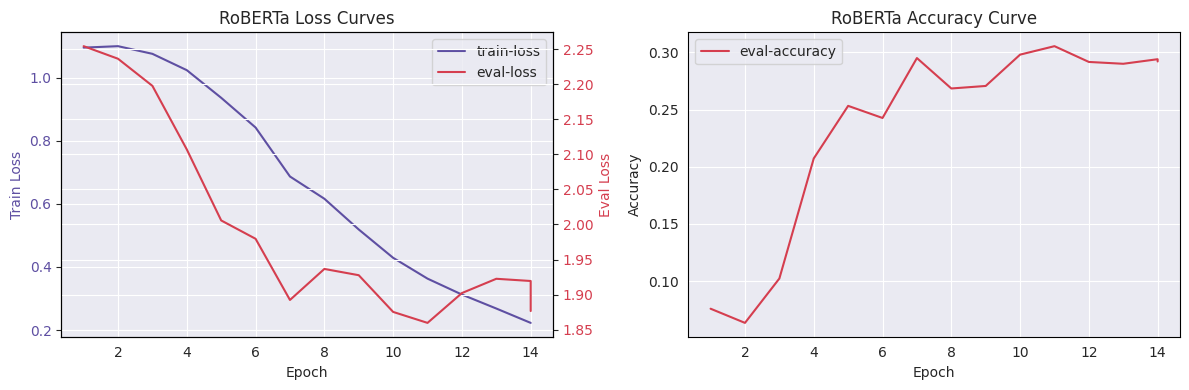

In [117]:
# Collect logs for training dynamics analysis
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if "loss" in e and e.get("epoch") is not None:
        train_loss.append(e["loss"])
        steps_train.append(e["epoch"])
    if "eval_loss" in e:
        eval_loss.append(e["eval_loss"])
        eval_acc.append(e["eval_accuracy"])
        steps_eval.append(e["epoch"])


def plot_bert_metrics(
    steps_train,
    train_loss,
    steps_eval,
    eval_loss,
    eval_acc,
    title_prefix="BERT",
    figsize=(12, 4),
    train_loss_color="#5e4fa2",
    eval_loss_color="#d53e4f",
    eval_acc_color="#d53e4f",
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left subplot: Loss curves with dual y-axes
    ax1 = axes[0]
    ax2 = ax1.twinx()  # Create second y-axis

    # Plot train loss on left y-axis
    line1 = ax1.plot(
        steps_train, train_loss, label="train-loss", color=train_loss_color
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss", color=train_loss_color)
    ax1.tick_params(axis="y", labelcolor=train_loss_color)

    # Plot eval loss on right y-axis
    line2 = ax2.plot(steps_eval, eval_loss, label="eval-loss", color=eval_loss_color)
    ax2.set_ylabel("Eval Loss", color=eval_loss_color)
    ax2.tick_params(axis="y", labelcolor=eval_loss_color)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    ax1.set_title(f"{title_prefix} Loss Curves")
    for spine in ax1.spines.values():
        spine.set_color("black")
    for spine in ax2.spines.values():
        spine.set_color("black")

    # Right subplot: Accuracy curve
    axes[1].plot(steps_eval, eval_acc, label="eval-accuracy", color=eval_acc_color)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].set_title(f"{title_prefix} Accuracy Curve")
    for spine in axes[1].spines.values():
        spine.set_color("black")

    plt.tight_layout()


plot_bert_metrics(
    steps_train, train_loss, steps_eval, eval_loss, eval_acc, title_prefix="RoBERTa"
)

The RoBERTa training curves with 32 labeled patent examples (∼3.6 samples per class) exhibits classic few-shot overfitting patterns, where training loss steadily decreases to 0.25 while validation loss hovers around 1.9 after epoch 6. The final accuracy of 29% represents a meaningful improvement over random baseline (11.1%) but remains modest, reflecting the extreme data scarcity challenge we face in the few shot setup here.

Patent classification compounds few-shot learning difficulties due to technical vocabulary, lengthy documents, and semantic overlap between patent classes, requiring sophisticated domain adaptation. The performance plateau after epoch 10 suggests the model quickly exhausted available training signal, indicating that alternative strategies like data augmentation may be necessary for substantial improvements in this setting. Therefore, we dive into deeper analysis hereinafter.

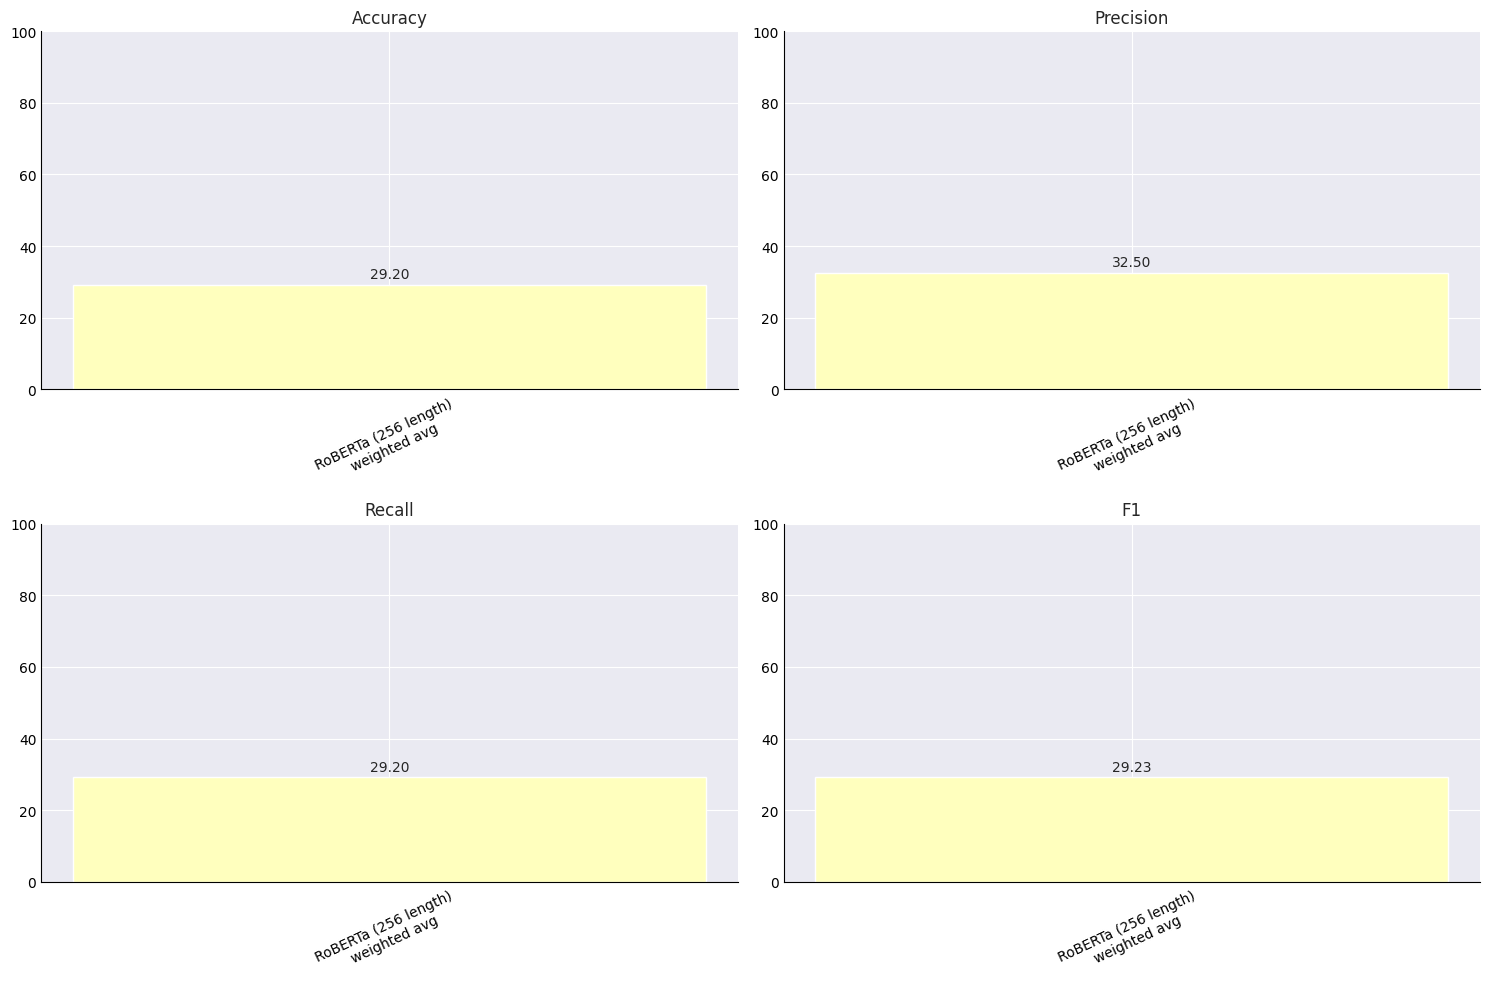

In [116]:
test_metrics = trainer.evaluate(dataset["test"])
predictions = trainer.predict(dataset["test"])

results = Metrics()
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
results.run(
    y_true, y_pred, "RoBERTa (256 length) \n weighted avg", average="weighted"
)
results.plot()

## **Confusion Matrix Analysis**



The confusion matrix reveals which patent categories are most difficult to distinguish with limited training data. We define here a general function which we will reuse in the next sections to visualize the confusion matrix for our models.

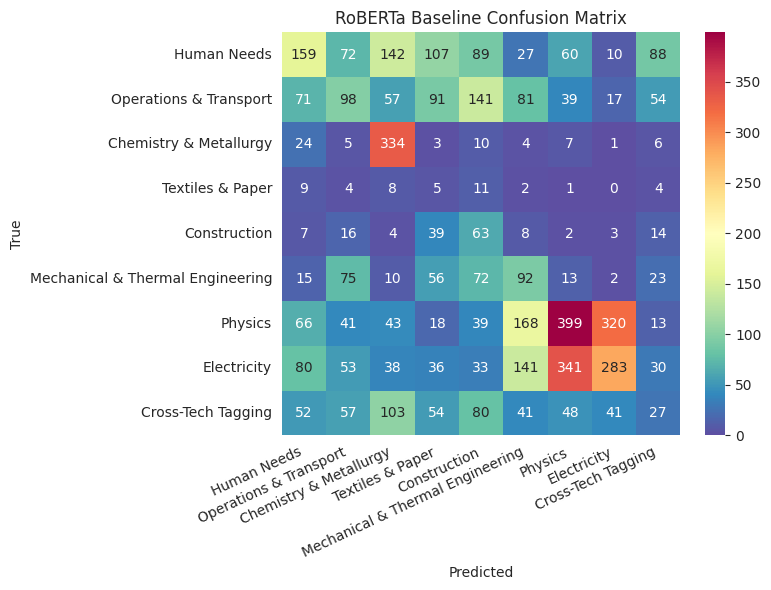

In [119]:
def plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, title="Confusion Matrix"):
    # Create confusion matrix with numeric labels
    cm = confusion_matrix(y_true, y_pred)

    # Get the actual labels present in the data
    unique_labels = sorted(set(y_true) | set(y_pred))
    class_names = [CLASS_NAMES[label] for label in unique_labels]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Spectral_r",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.xticks(rotation=25, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm


cm = plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, "RoBERTa Baseline Confusion Matrix")

 **Expected confusion patterns:**

 - **Physics vs. Electricity**: Often overlap in semiconductor/electronic patents

 - **Chemistry vs. Human Needs**: Pharmaceutical patents can belong to either category

 - **Mechanical vs. Construction**: Building systems and machinery patents share vocabulary

## **Overall Performance Pattern**

The confusion matrix reveals classification challenges, with Chemistry & Metallurgy achieving the strongest performance (334 correct predictions) probably due to its distinctive chemical vocabulary, while Physics and Electricity show severe mutual confusion (399 Physics samples misclassified as Electricity, 341 vice versa), indicating overlapping technical terminology.

Class imbalance severely impacts performance, with some categories like Textiles & Paper having very few samples, while larger classes like Physics and Electricity dominate predictions. Cross-Tech Tagging exhibits the poorest classification accuracy with predictions scattered across all categories, reflecting its inherently ambiguous nature as a catch-all category. The model demonstrates domain-specific strengths in chemically-focused patents but struggles with electrical/physical engineering domains where technical concepts and vocabulary overlap substantially.

 ## **BERT Interpretability: Understanding Patent Classification Decisions**



 To understand what BERT learns from limited patent data, we analyze which words most influence classification decisions with the following code, based on the developments of [University of Mannheim](https://socialsciencedatalab.mzes.uni-mannheim.de/article/bert-explainable-ai/) and the `transformers_interpret` library.

In [120]:
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns


def bert_interpretability_analysis(
    model, tokenizer, confused_examples, target_labels=None
):
    """
    Generalized BERT interpretation for any label confusion

    Args:
        model: Trained model
        tokenizer: Model tokenizer
        confused_examples: List of (text, true_label, pred_label) tuples
        target_labels: Optional tuple of (true_label, pred_label) to filter for
    """

    # Initialize the explainer
    explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
    analysis_results = []

    # Filter examples if target_labels specified
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [
            (text, true, pred)
            for text, true, pred in confused_examples
            if true == true_target and pred == pred_target
        ]
        print(
            f"🎯 Focusing on: {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]}"
        )

    # Process top 3 examples for visualization and analysis
    for i, (text, true_label, pred_label) in enumerate(confused_examples[:3]):
        print(f"\n{'=' * 50}")
        print(f"CONFUSED EXAMPLE {i + 1}")
        print(f"True: {CLASS_NAMES[true_label]} | Predicted: {CLASS_NAMES[pred_label]}")

        # Truncate text to fit model's max length
        tokens = tokenizer.encode(text, add_special_tokens=False)
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            text = tokenizer.decode(tokens, skip_special_tokens=True)
            print(f"⚠️  Text truncated to {len(tokens)} tokens")

        print(f"Text snippet: {text[:150]}...")

        try:
            # Get word attributions
            word_attributions = explainer(text)

            # Create visualization
            try:
                explainer.visualize(
                    f"confusion_{CLASS_NAMES[true_label].replace(' ', '_')}_to_{CLASS_NAMES[pred_label].replace(' ', '_')}_{i + 1}"
                )
                print(f"📊 Visualization saved as HTML file")
            except Exception as viz_error:
                print(f"⚠️  HTML visualization failed: {viz_error}")

                # Fallback matplotlib plot
                words = [word for word, score in word_attributions[:15]]
                scores = [score for word, score in word_attributions[:15]]

                plt.figure(figsize=(12, 6))
                colors = ["red" if s < 0 else "green" for s in scores]
                plt.barh(range(len(words)), scores, color=colors, alpha=0.7)
                plt.yticks(range(len(words)), words)
                plt.xlabel("Attribution Score")
                plt.title(
                    f"Example {i + 1}: {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}"
                )
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            # Store attribution data
            attribution_data = []
            for word, score in word_attributions:
                attribution_data.append(
                    {"word": word, "attribution": score, "abs_attribution": abs(score)}
                )

            attribution_df = pd.DataFrame(attribution_data)
            attribution_df = attribution_df.sort_values(
                "abs_attribution", ascending=False
            )

            print(f"\n🔍 Top 10 most influential words:")
            for _, row in attribution_df.head(10).iterrows():
                direction = "→" if row["attribution"] > 0 else "←"
                print(f"  {direction} '{row['word']}': {row['attribution']:.4f}")

            analysis_results.append(
                {
                    "example_id": i,
                    "true_label": true_label,
                    "pred_label": pred_label,
                    "text": text,
                    "attributions": attribution_df,
                }
            )

        except Exception as e:
            print(f"❌ Error processing example {i}: {e}")
            continue

    return analysis_results


def analyze_confusion_patterns_general(analysis_results, label_pair=None):
    """
    Generalized confusion pattern analysis for any label pair

    Args:
        analysis_results: Results from interpretability analysis
        label_pair: Optional (true_label, pred_label) tuple to focus on
    """

    print(f"\n{'=' * 60}")
    print("CONFUSION PATTERN ANALYSIS")
    print(f"{'=' * 60}")

    if label_pair:
        true_label, pred_label = label_pair
        # Filter for specific confusion direction
        filtered_results = [
            r
            for r in analysis_results
            if r["true_label"] == true_label and r["pred_label"] == pred_label
        ]

        if filtered_results:
            print(
                f"\n🎯 {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]} ({len(filtered_results)} examples):"
            )

            # Find common influential words
            common_words = defaultdict(list)
            for result in filtered_results:
                top_words = result["attributions"].head(15)
                for _, row in top_words.iterrows():
                    if row["attribution"] > 0:  # Words pushing toward predicted class
                        common_words[row["word"]].append(row["attribution"])

            # Show most misleading words
            avg_attribution = {
                word: np.mean(scores)
                for word, scores in common_words.items()
                if len(scores) >= 1
            }

            if avg_attribution:
                sorted_words = sorted(
                    avg_attribution.items(), key=lambda x: x[1], reverse=True
                )
                print(
                    f"Words misleading model toward '{CLASS_NAMES[pred_label]}' prediction:"
                )
                for word, avg_score in sorted_words[:10]:
                    freq = len(common_words[word])
                    print(f"  '{word}': {avg_score:.4f} (appears {freq}x)")
    else:
        # Analyze all confusion patterns
        confusion_groups = defaultdict(list)
        for result in analysis_results:
            key = (result["true_label"], result["pred_label"])
            confusion_groups[key].append(result)

        for (true_label, pred_label), results in confusion_groups.items():
            print(
                f"\n🎯 {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]} ({len(results)} examples):"
            )

            common_words = defaultdict(list)
            for result in results:
                top_words = result["attributions"].head(10)
                for _, row in top_words.iterrows():
                    if row["attribution"] > 0:
                        common_words[row["word"]].append(row["attribution"])

            avg_attribution = {
                word: np.mean(scores)
                for word, scores in common_words.items()
                if len(scores) >= 1
            }

            if avg_attribution:
                sorted_words = sorted(
                    avg_attribution.items(), key=lambda x: x[1], reverse=True
                )
                print(f"  Top misleading words:")
                for word, avg_score in sorted_words[:5]:
                    freq = len(common_words[word])
                    print(f"    • '{word}': {avg_score:.4f} ({freq}x)")


def find_most_confused_pairs(y_true, y_pred, top_n=5):
    """
    Automatically find the most confused label pairs

    Args:
        y_true: True labels
        y_pred: Predicted labels
        top_n: Number of top confused pairs to return

    Returns:
        List of (true_label, pred_label, count) tuples
    """

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Find off-diagonal elements (misclassifications)
    confused_pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:  # Misclassification
                confused_pairs.append((i, j, cm[i][j]))

    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"🔍 Top {top_n} most confused label pairs:")
    for i, (true_label, pred_label, count) in enumerate(confused_pairs[:top_n]):
        print(
            f"  {i + 1}. {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}: {count} examples"
        )

    return confused_pairs[:top_n]


def investigate_label_confusion_comprehensive(
    trainer, original_dataset, tokenizer, target_labels=None, auto_find_top=True
):
    """
    Comprehensive label confusion analysis

    Args:
        trainer: Trained model trainer
        original_dataset: Dataset with text column
        tokenizer: Model tokenizer
        target_labels: Optional (true_label, pred_label) tuple to focus on
        auto_find_top: Whether to automatically find most confused pairs first
    """

    print("🔍 Starting Comprehensive Label Confusion Analysis...")
    print("=" * 60)

    # Get predictions
    predictions = trainer.predict(original_dataset["test"])
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    test_texts = original_dataset["test"]["text"]

    # Auto-find most confused pairs if requested
    if auto_find_top and target_labels is None:
        most_confused = find_most_confused_pairs(y_true, y_pred, top_n=5)

        # Ask user which pair to analyze (or automatically pick the top one)
        if most_confused:
            target_labels = (most_confused[0][0], most_confused[0][1])
            print(
                f"\n🎯 Auto-selected: {CLASS_NAMES[target_labels[0]]} → {CLASS_NAMES[target_labels[1]]}"
            )

    # Find confused examples
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [
            (text, true_label, pred_label)
            for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
            if true_label == true_target and pred_label == pred_target
        ]
        print(
            f"\nFound {len(confused_examples)} examples of {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]} confusion"
        )
    else:
        # Analyze all misclassifications
        confused_examples = [
            (text, true_label, pred_label)
            for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
            if true_label != pred_label
        ]
        print(f"\nFound {len(confused_examples)} total misclassified examples")

    if len(confused_examples) == 0:
        print("✅ No confusion found!")
        return None, None

    # Run interpretability analysis
    print(f"\n🔬 Running attribution analysis on top 3 examples...")
    analysis_results = bert_interpretability_analysis(
        trainer.model, tokenizer, confused_examples, target_labels
    )

    if analysis_results:
        # Analyze patterns
        print(f"\n📊 Analyzing confusion patterns...")
        analyze_confusion_patterns_general(analysis_results, target_labels)

        return analysis_results, confused_examples
    else:
        print("❌ No successful analyses completed")
        return None, None


# Potential usages

# 1. Analyze specific label pair
def analyze_specific_confusion(trainer, dataset, tokenizer, true_label, pred_label):
    """Analyze confusion between two specific labels"""
    return investigate_label_confusion_comprehensive(
        trainer,
        dataset,
        tokenizer,
        target_labels=(true_label, pred_label),
        auto_find_top=False,
    )


# 2. Auto-find and analyze top confusions
def analyze_top_confusions(trainer, dataset, tokenizer):
    """Automatically find and analyze most confused pairs"""
    return investigate_label_confusion_comprehensive(
        trainer, dataset, tokenizer, target_labels=None, auto_find_top=True
    )


# 3. Analyze all confusions
def analyze_all_confusions(trainer, dataset, tokenizer):
    """Analyze patterns across all label confusions"""
    return investigate_label_confusion_comprehensive(
        trainer, dataset, tokenizer, target_labels=None, auto_find_top=False
    )


# Option 1: Analyze specific confusion (Textiles → Electricity)
# _ = analyze_specific_confusion(trainer, original_dataset, tok, 3, 7)

# Option 2: Auto-find most confused pairs
_ = analyze_top_confusions(trainer, original_dataset, tok)

# Option 3: Manual investigation
# _ = investigate_label_confusion_comprehensive(trainer, original_dataset, tok)

🔍 Starting Comprehensive Label Confusion Analysis...


🔍 Top 5 most confused label pairs:
  1. Electricity → Physics: 341 examples
  2. Physics → Electricity: 320 examples
  3. Physics → Mechanical & Thermal Engineering: 168 examples
  4. Human Needs → Chemistry & Metallurgy: 142 examples
  5. Operations & Transport → Construction: 141 examples

🎯 Auto-selected: Electricity → Physics

Found 341 examples of Electricity → Physics confusion

🔬 Running attribution analysis on top 3 examples...
🎯 Focusing on: Electricity → Physics

CONFUSED EXAMPLE 1
True: Electricity | Predicted: Physics
Text snippet: a latch circuit for temporarily storing an input signal and successively outputting the input signal is disclosed , that comprises an input transfer c...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'signal': 0.2757
  → 'circuit': 0.2555
  → 'signal': 0.2413
  → 'circuit': 0.2231
  → 'inver': 0.2141
  → 'circuit': 0.2129
  → 'clock': 0.2040
  → 'circuit': 0.1889
  → 'signal': 0.1883
  → 'inver': 0.1732

CONFUSED EXAMPLE 2
True: Electricity | Predicted: Physics
Text snippet: a television tuner contains a mixer unit for converting a television signal into an intermediate frequency signal and an intermediate frequency tuning...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'tuning': 0.3059
  → 'signal': 0.2241
  → 'tuning': 0.2037
  → 'tuning': 0.2011
  → 'field': 0.2006
  → 'converting': 0.1916
  → 'signal': 0.1906
  → 'television': 0.1870
  → 'signal': 0.1780
  → 'field': 0.1618

CONFUSED EXAMPLE 3
True: Electricity | Predicted: Physics
Text snippet: a surface emitting light emitting device with a semiconducting substrate , a semiconducting mirror stack positioned on the substrate surface , a space...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'device': 0.3215
  → 'stack': 0.2818
  → 'onduct': 0.2090
  ← 'and': -0.2088
  → 'stack': 0.2039
  ← 'contact': -0.1877
  → 'quantum': 0.1724
  → 'onduct': 0.1576
  ← 'wavelength': -0.1536
  → 'stack': 0.1464

📊 Analyzing confusion patterns...

CONFUSION PATTERN ANALYSIS

🎯 Electricity → Physics (3 examples):
Words misleading model toward 'Physics' prediction:
  'device': 0.3215 (appears 1x)
  'tuning': 0.2369 (appears 3x)
  'circuit': 0.2201 (appears 4x)
  'signal': 0.1969 (appears 9x)
  'inver': 0.1936 (appears 2x)
  'stack': 0.1927 (appears 4x)
  'converting': 0.1916 (appears 1x)
  'onduct': 0.1833 (appears 2x)
  'clock': 0.1739 (appears 2x)
  'quantum': 0.1724 (appears 1x)


## **Major Misclassification Patterns**

The model's primary confusion between Electricity and Physics (341 misclassified examples) stems from overlapping technical vocabulary, with key misleading terms including 'signal', 'circuit', 'device', 'tuning', and 'quantum' that appear frequently in both domains. Attribution analysis reveals that patents involving latch circuits, television tuners, and semiconductor devices are particularly problematic, as they contain electrical engineering concepts (circuits, signals) alongside physics terminology (quantum wells, electromagnetic fields).

The model appears to over-rely on individual technical terms rather than understanding domain-specific contexts - for instance, 'signal' and 'circuit' strongly push predictions toward Physics despite being core electrical engineering concepts. This suggests the need for better contextual understanding or domain-specific fine-tuning to distinguish between electrical engineering applications and fundamental physics research, particularly in semiconductor and signal processing patents where the vocabularies substantially overlap.

## Bottomline: Few-shot approach

The attribution analysis reveals fundamental weaknesses in the BERT baseline's approach to patent classification, where the model over-relies on surface-level technical vocabulary rather than understanding domain-specific contexts and applications. Critical terms like 'signal', 'circuit', 'device', and 'quantum' appear across multiple patent categories but with different contextual meanings - the model fails to distinguish between electrical engineering applications versus fundamental physics research, or mechanical systems versus electronic implementations. This vocabulary overlap explains the systematic confusion patterns observed in the matrix, particularly between technically adjacent domains (Physics↔Electricity, Operations & Transport↔Construction), where shared terminology masks distinct functional applications.

Generally, this is not suprising, as the EDA part showed, that there exists fundamental overalp between some classes which makes classification invariably harder.

The model's token-level attribution approach so far lacks the semantic understanding necessary for patent classification, where the application context and intended use of technologies are more discriminative than individual technical terms.

 # **2. Dataset Augmentation**

 ---



 To address the data scarcity, this section explores automated augmentation techniques that **do not rely on large language models (LLMs)**. We focus on techniques that preserve semantic meaning while adding surface-level variation.



 **Why avoid LLMs for augmentation:**

 - Cost: API calls for generating thousands of examples

 - Quality control: LLMs may introduce domain-inappropriate language

 - Reproducibility: Non-deterministic generation complicates experiments

 - Privacy: Sending patent data to external APIs may violate confidentiality



 **Patent-specific augmentation opportunities:**

 - Patents have multi-section structure (abstract, claims, description)

 - Many patents describe multiple independent embodiments

 - Technical claims can often be reordered without changing meaning

 - Section-level shuffling preserves semantic content

In [121]:
dataset = load_dataset("ccdv/patent-classification", "abstract")

sample_training = dataset["train"].shuffle(seed=seed)
sample_training = keep_n_per_class(sample_training, 4)

<ipython-input-110-1420630012>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n), random_state=seed))


 ## **Sentence Shuffling Augmentation**



 Patent documents often contain multiple independent technical claims that can be reordered without changing the overall classification.



 **Why this should work for patents:**

 - Patents describe multiple embodiments ("In another embodiment...")

 - Claims are often legally independent

 - Background sections contain multiple prior art references

 - Implementation details can be described in various orders



 **Process:**

 1. Split each patent text into sentences using SpaCy

 2. Randomly shuffle sentence order

 3. Reconstruct text with new ordering

 4. Keep original label (meaning preserved)

In [122]:
import spacy

nlp = spacy.load("en_core_web_sm")


def sent_tokenize(text):
    return [sent.text for sent in nlp(text).sents]


def oversample_by_sentence_shuffling(
    dataset, n_samples_per_class, text_col="text", label_col="label", seed=42
):
    random.seed(seed)
    df = dataset.to_pandas()

    # Count current class distribution
    class_groups = df.groupby(label_col)
    augmented_rows = []

    for label, group in class_groups:
        current_count = len(group)
        needed = n_samples_per_class - current_count

        # If already enough samples, keep as-is
        if needed <= 0:
            continue

        # Pick samples to augment (with replacement if needed)
        samples_to_augment = group.sample(n=needed, replace=True, random_state=seed)

        for _, row in samples_to_augment.iterrows():
            original_text = row[text_col]
            sentences = sent_tokenize(original_text)
            if len(sentences) > 1:
                random.shuffle(sentences)
                new_text = " ".join(sentences)
            else:
                new_text = original_text  # can't shuffle single sentence

            augmented_rows.append({text_col: new_text, label_col: label})

    # Build augmented DataFrame
    df_augmented = pd.DataFrame(augmented_rows)

    # Combine original + augmented
    df_combined = pd.concat([df, df_augmented], ignore_index=True)

    # Shuffle final dataset
    df_combined = df_combined.sample(frac=1, random_state=seed).reset_index(drop=True)

    return DatasetDict({"train": Dataset.from_pandas(df_combined)})

 ## **Training on Augmented Data: Quality vs. Quantity Trade-off**



 We're now training on ~90 samples instead of 32 (reflecting the oversampling of undrepresented classes.) Now each class (in total 9) has an exactly equal amount of examples in the training data. The key question: Does the additional quantity compensate for potential quality degradation from shuffled sentences?



 **Hypothesis**: Sentence shuffling preserves semantic content while adding diversity, leading to better generalization.

In [123]:
oversampled_dataset = oversample_by_sentence_shuffling(
    sample_training["train"],
    n_samples_per_class=10,
    text_col="text",
    label_col="label",
    seed=seed,
)

tok = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize(batch):
    return tok(
        batch["text"], padding="max_length", truncation=True, max_length=max_length
    )


dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
dataset.set_format("torch")

oversampled_dataset = oversampled_dataset.map(
    tokenize, batched=True, remove_columns=["text"]
)
oversampled_dataset.set_format("torch")

aug_args = TrainingArguments(
    output_dir="./final_project_aug",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=50,
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=2,
    seed=seed,
    report_to="none",  # Disable wandb
    fp16=False,  # Enable mixed precision training
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

aug_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels, problem_type="single_label_classification"
)

aug_trainer = Trainer(
    model=aug_model,
    args=aug_args,
    train_dataset=oversampled_dataset["train"],
    eval_dataset=dataset["validation"].shuffle(
        seed=seed
    ),  # small held-out set for early-stop
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

train_output = aug_trainer.train()

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.220400,2.182566,0.141000,0.019881,0.141000,0.034848
2,2.188200,2.208054,0.008200,0.070564,0.008200,0.000526
3,2.167400,2.164314,0.186200,0.175190,0.186200,0.120470
4,2.060200,2.131060,0.213400,0.137750,0.213400,0.152456
5,1.818900,2.053520,0.212800,0.320391,0.212800,0.187635
6,1.540500,1.920340,0.291000,0.336941,0.291000,0.272252
7,1.234800,1.855509,0.308200,0.320629,0.308200,0.279732
8,1.076600,1.868281,0.303600,0.317961,0.303600,0.287476
9,0.875700,1.879558,0.300400,0.342400,0.300400,0.292411
10,0.724900,1.828812,0.319400,0.348467,0.319400,0.301963


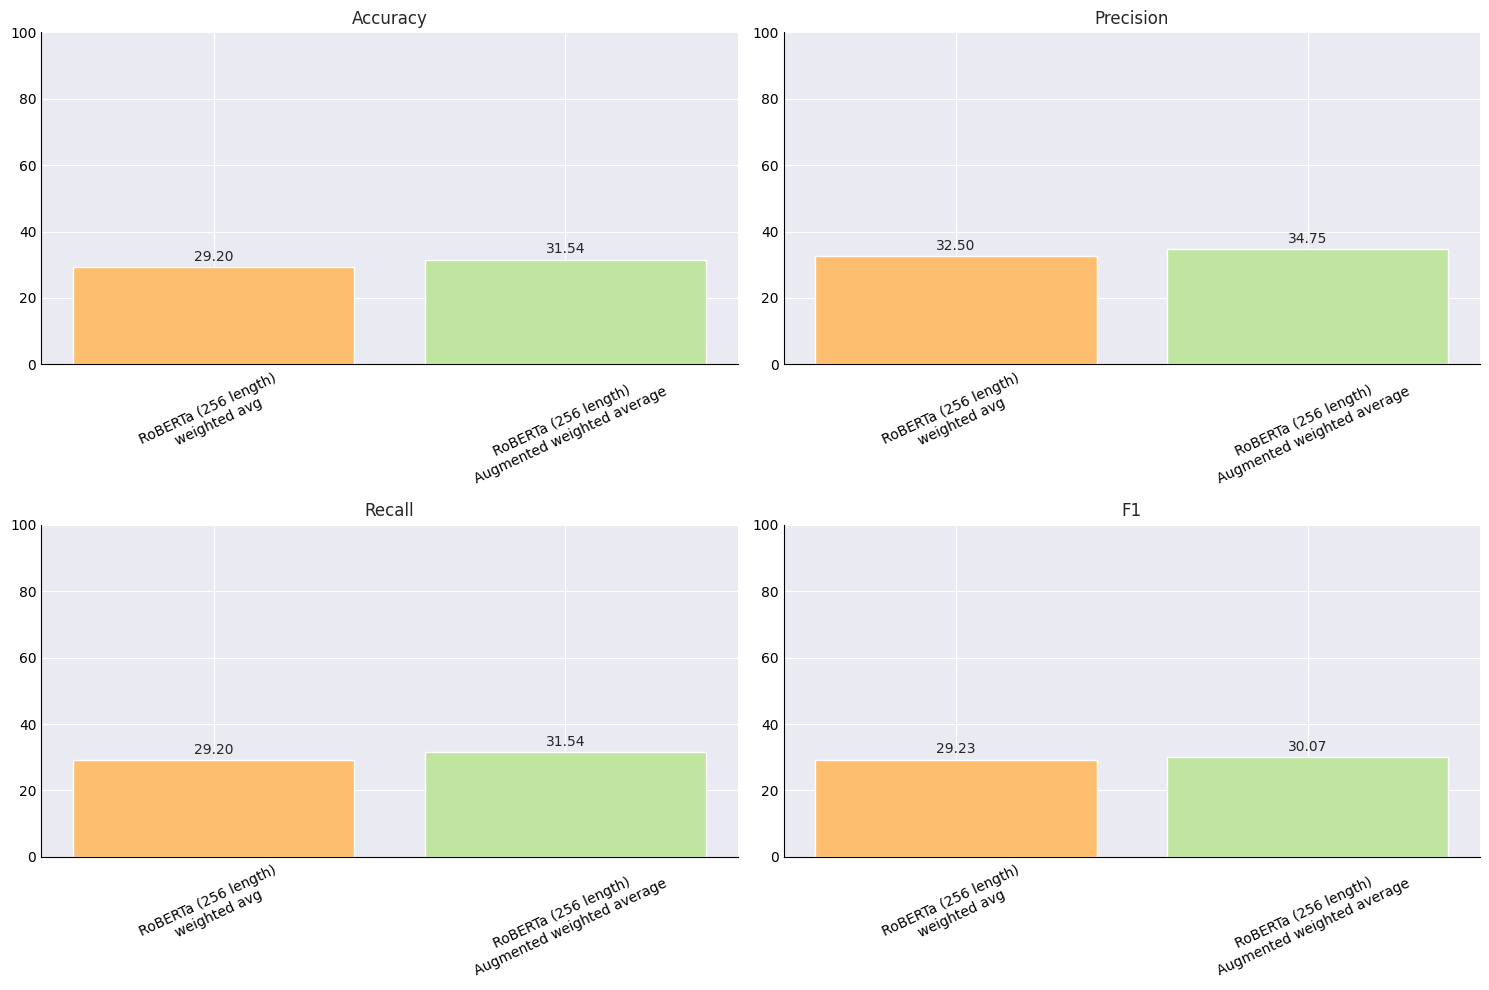

In [124]:
predictions_aug = aug_trainer.predict(dataset["test"])

y_pred_aug = np.argmax(predictions_aug.predictions, axis=1)
y_true_aug = predictions_aug.label_ids
results.run(
    y_true_aug,
    y_pred_aug,
    "RoBERTa (256 length)\n Augmented weighted average",
    average="weighted",
)
results.plot()

Data augmentation via sentence reshuffling and oversampling yields meaningful improvements across all metrics, with accuracy increasing from 29.20% to 31.54% (+2.34 percentage points) and similar gains in precision and recall, demonstrating that structural variation helps the model generalize better in the few-shot setting.

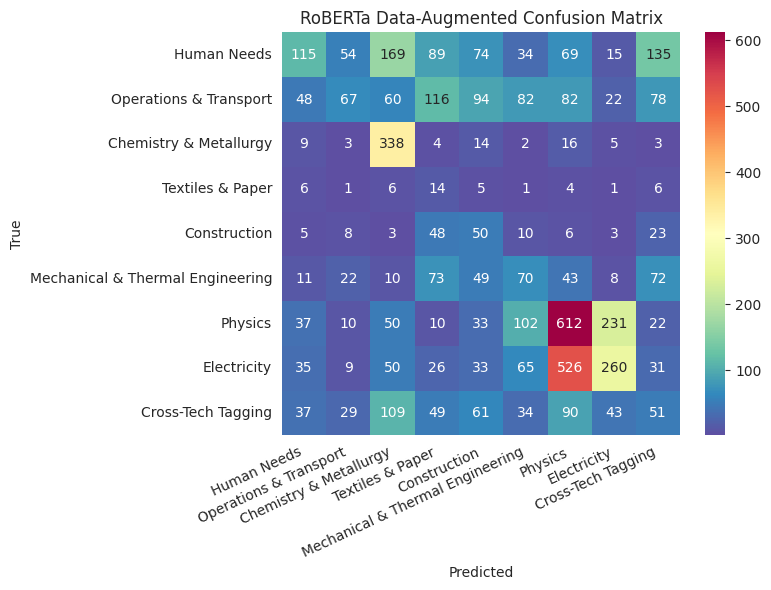

In [125]:
# Plot confusion matrix
cm_aug = plot_confusion_matrix(
    y_true_aug, y_pred_aug, CLASS_NAMES, "RoBERTa Data-Augmented Confusion Matrix"
)

The augmentation strategy works by creating additional training examples through sentence reordering, which forces the model to learn more robust representations that are less dependent on specific sentence sequences - particularly valuable for patent documents where key information can appear in different structural positions.

Comparing to the baseline BERT confusion matrix, the augmented RoBERTa shows mixed Physics↔Electricity results (231 vs. 399 misclassifications for Physics→Electricity improved, but 526 vs. 341 for Electricity→Physics worsened), suggesting that sentence reshuffling created an asymmetric bias where the model became better at identifying Physics but more prone to misclassifying Electricity patents as Physics.

The augmented model maintains Chemistry & Metallurgy's strong performance (334 correct) while showing more balanced predictions across other categories, indicating that the structural variation introduced by reshuffling helps combat the model's tendency to over-rely on surface-level sequential patterns that may not generalize across patent document styles.

In [127]:
_ = analyze_top_confusions(aug_trainer, original_dataset, tok)

🔍 Starting Comprehensive Label Confusion Analysis...


🔍 Top 5 most confused label pairs:
  1. Electricity → Physics: 526 examples
  2. Physics → Electricity: 231 examples
  3. Human Needs → Chemistry & Metallurgy: 169 examples
  4. Human Needs → Cross-Tech Tagging: 135 examples
  5. Operations & Transport → Textiles & Paper: 116 examples

🎯 Auto-selected: Electricity → Physics

Found 526 examples of Electricity → Physics confusion

🔬 Running attribution analysis on top 3 examples...
🎯 Focusing on: Electricity → Physics

CONFUSED EXAMPLE 1
True: Electricity | Predicted: Physics
Text snippet: an image processing apparatus for performing a white balance correction for raw data obtained by an image capturing unit , includes a storage , operab...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'stored': 0.2492
  → '': 0.2396
  → ',': 0.2362
  → 'includes': 0.2315
  → ',': 0.2106
  → 'apparatus': 0.1915
  → 'raw': 0.1909
  ← 'the': -0.1774
  → 'correction': 0.1763
  → 'raw': 0.1753

CONFUSED EXAMPLE 2
True: Electricity | Predicted: Physics
Text snippet: a card connector comprises an insulating housing ; a plurality of contacts retained in the insulating housing ; a shielding being approximate encircle...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'inserting': 0.4016
  → 'connector': 0.2385
  → ';': 0.2368
  → ';': 0.2112
  → 'shielding': 0.1877
  → 'card': 0.1848
  → 'shielding': 0.1775
  → 'plurality': 0.1708
  ← 'and': -0.1654
  → 'inserting': 0.1632

CONFUSED EXAMPLE 3
True: Electricity | Predicted: Physics
Text snippet: a latch circuit for temporarily storing an input signal and successively outputting the input signal is disclosed , that comprises an input transfer c...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'input': 0.2858
  → 'delay': 0.2613
  → 'reference': 0.2577
  → 'input': 0.2444
  → 'input': 0.2359
  → 'circuit': 0.2326
  → 'input': 0.1889
  → 'signal': 0.1828
  → 'clock': 0.1821
  → 'output': 0.1818

📊 Analyzing confusion patterns...

CONFUSION PATTERN ANALYSIS

🎯 Electricity → Physics (3 examples):
Words misleading model toward 'Physics' prediction:
  'inserting': 0.2824 (appears 2x)
  'delay': 0.2613 (appears 1x)
  'reference': 0.2577 (appears 1x)
  'stored': 0.2492 (appears 1x)
  'input': 0.2388 (appears 4x)
  'connector': 0.2385 (appears 1x)
  'includes': 0.2315 (appears 1x)
  ';': 0.2240 (appears 2x)
  ',': 0.2234 (appears 2x)
  '': 0.1921 (appears 2x)


The sentence-shuffled augmented model shows a stark worsening of Electricity→Physics confusion (526 vs 341 examples), with a fundamental shift in the vocabulary driving misclassifications from technical domain terms to functional/operational language.

The attribution analysis reveals that misleading terms have shifted from circuit-focused vocabulary to procedural words ('inserting', 'delay', 'reference', 'stored', 'input', 'connector'), suggesting sentence reshuffling exposed the model to contexts where these functional terms appear across patent structures. This vocabulary transformation indicates that while sentence reordering reduced dependence on positional patterns, it inadvertently taught the model to associate common patent procedural language with Physics rather than recognizing them as domain-neutral terms.

The confusion now stems from patents involving connectors, image processing apparatus, and circuit storage mechanisms, demonstrating how structural augmentation can introduce new systematic biases even while improving overall classification performance.

 # **3. Zero-Shot Learning with LLM**

 ---



 Here, we evaluate how well an LLM (Mistral) can classify patents without fine-tuning, relying on its general knowledge and a well-crafted prompt.



 **Why zero-shot matters for patent classification:**

 - **New technology domains**: When patent categories emerge (e.g., AI, blockchain), no training data exists

 - **Quick prototyping**: Assess classification feasibility before investing in labeling

 - **Cross-domain transfer**: Leverage general knowledge for specialized patent language

 - **Cost analysis**: Compare API costs vs. manual labeling + training costs



 **Key challenges:**

 - Patent language is highly technical and domain-specific

 - Categories like "Cross-Tech Tagging" are abstract and poorly defined

 - LLMs trained on general text may miss patent-specific nuances

 - Non-deterministic outputs complicate evaluation

In [24]:
import time

import numpy as np
from mistralai import Mistral
from pydantic import BaseModel

# Check for API key
try:
    from google.colab import userdata

    api_key = userdata.get("MISTRAL_API")
except ImportError:
    try:
        from dotenv import load_dotenv

        load_dotenv()
        api_key = os.getenv("MISTRAL_API")
    except ImportError:
        api_key = None

# Initialize Mistral client
client = Mistral(api_key=api_key) if api_key else None


# We use a Pydantic model for structured responses
class PatentClassificationResponse(BaseModel):
    classification: int
    confidence: float
    reasoning: str

 ## **Structured Prompting for Patent Classification**



 Effective zero-shot classification requires carefully designed prompts that:

 - Clearly define each of the 9 patent categories

 - Provide classification guidelines (focus on technical content, not keywords)

 - Request confidence scores for reliability filtering

 - Ask for reasoning to enable error analysis


 This is why we use a pydantic datamodel, which ensures coherence with our required output while making JSON parsing redundant.

In [25]:
def retry_with_backoff(func, max_retries=3, base_delay=2.0):
    """Simple retry wrapper with exponential backoff for rate limits"""
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            error_str = str(e).lower()

            # Check if it's a rate limit error
            if any(
                phrase in error_str
                for phrase in ["rate limit", "429", "too many requests"]
            ):
                if attempt < max_retries - 1:  # Don't sleep on last attempt
                    delay = base_delay * (2**attempt) + random.uniform(0, 1)
                    print(
                        f"Rate limit hit, retrying in {delay:.1f} seconds... (attempt {attempt + 1}/{max_retries})"
                    )
                    time.sleep(delay)
                    continue

            # For non-rate-limit errors, raise immediately
            raise e

    # If we get here, all retries failed
    raise Exception(f"Failed after {max_retries} attempts")


def classify_patent_zero_shot(
    text: str, model: str = "mistral-small-2503"
) -> PatentClassificationResponse:
    """
    Classify patent text using Mistral API in zero-shot setting
    """
    if client is None:
        return PatentClassificationResponse(
            classification=0, confidence=0.0, reasoning="API client not available"
        )

    # Create comprehensive system prompt
    system_prompt = f"""You are an expert patent classifier. You will classify patent texts into one of 9 categories.

CLASSIFICATION CATEGORIES:
{chr(10).join([f"{k}: {v}" for k, v in CLASS_NAMES.items()])}

TASK: Classify the given patent text into one of the 9 categories above.

REQUIREMENTS:
- Return classification as integer (0-8)
- Provide confidence score (0.0-1.0)
- Give brief reasoning for your classification
- Base classification on technical content and patent domain"""

    def make_api_call():
        response = client.chat.parse(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Classify this patent text:\n\n{text}"},
            ],
            response_format=PatentClassificationResponse,
            temperature=0.1,
            max_tokens=500,
        )
        return response

    try:
        # Use retry wrapper for the API call
        response = retry_with_backoff(make_api_call)
        return response.choices[0].message.parsed

    except Exception as e:
        print(f"API call failed: {e}")
        return PatentClassificationResponse(
            classification=0, confidence=0.0, reasoning=f"API error: {str(e)}"
        )

 ## **Zero-Shot Evaluation on Balanced Test Set**



 We evaluate on a balanced subset of 32 test examples (same size as our training set) to reduce API cost and load times. We run our prompts against one of MistralAIs smaller models.

In [26]:
# Sample 32 samples from the test data for zero-shot evaluation
test_subset_size = 32
dat = load_dataset("ccdv/patent-classification", "abstract")
test_subset = keep_n_per_class(dat["test"], test_subset_size)["train"]

print(f"🔍 Evaluating zero-shot performance on {test_subset_size} test samples...")

# Perform zero-shot classification
zero_shot_results = []
y_pred_llm = []
y_true_llm = []

if os.path.exists("zero_shot_results.pkl"):
    with open("zero_shot_results.pkl", "rb") as f:
        zero_shot_results = pickle.load(f)
        y_pred_llm = [result["classification"] for result in zero_shot_results]
        y_true_llm = [example["label"] for example in test_subset]
    print("Loaded pickled data")
elif client is not None:
    print("Running zero-shot classification with Mistral...")

    for i, example in enumerate(test_subset):
        try:
            # Rate limiting - respect API limits
            time.sleep(2)  # 1 request per second limit

            # Get zero-shot prediction
            result = classify_patent_zero_shot(example["text"])

            zero_shot_results.append(
                {
                    "classification": result.classification,
                    "confidence": result.confidence,
                    "reasoning": result.reasoning,
                }
            )

            # Ensure prediction is in valid range
            pred = max(0, min(8, result.classification))
            y_pred_llm.append(pred)
            y_true_llm.append(example["label"])

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{test_subset_size} samples...")

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            # Add fallback prediction
            zero_shot_results.append(
                {
                    "classification": 0,
                    "confidence": 0.0,
                    "reasoning": f"Processing error: {str(e)}",
                }
            )
            y_pred_llm.append(0)
            y_true_llm.append(example["label"])

    # Pickle results to not need to rerun the code again
    with open("zero_shot_results.pkl", "wb") as f:
        pickle.dump(zero_shot_results, f)

    print(f"✅ Completed zero-shot classification of {len(y_pred_llm)} samples")
else:
    print("⚠️ Skipping zero-shot classification - API client not available")

🔍 Evaluating zero-shot performance on 32 test samples...
Loaded pickled data


<ipython-input-5-1420630012>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n), random_state=seed))


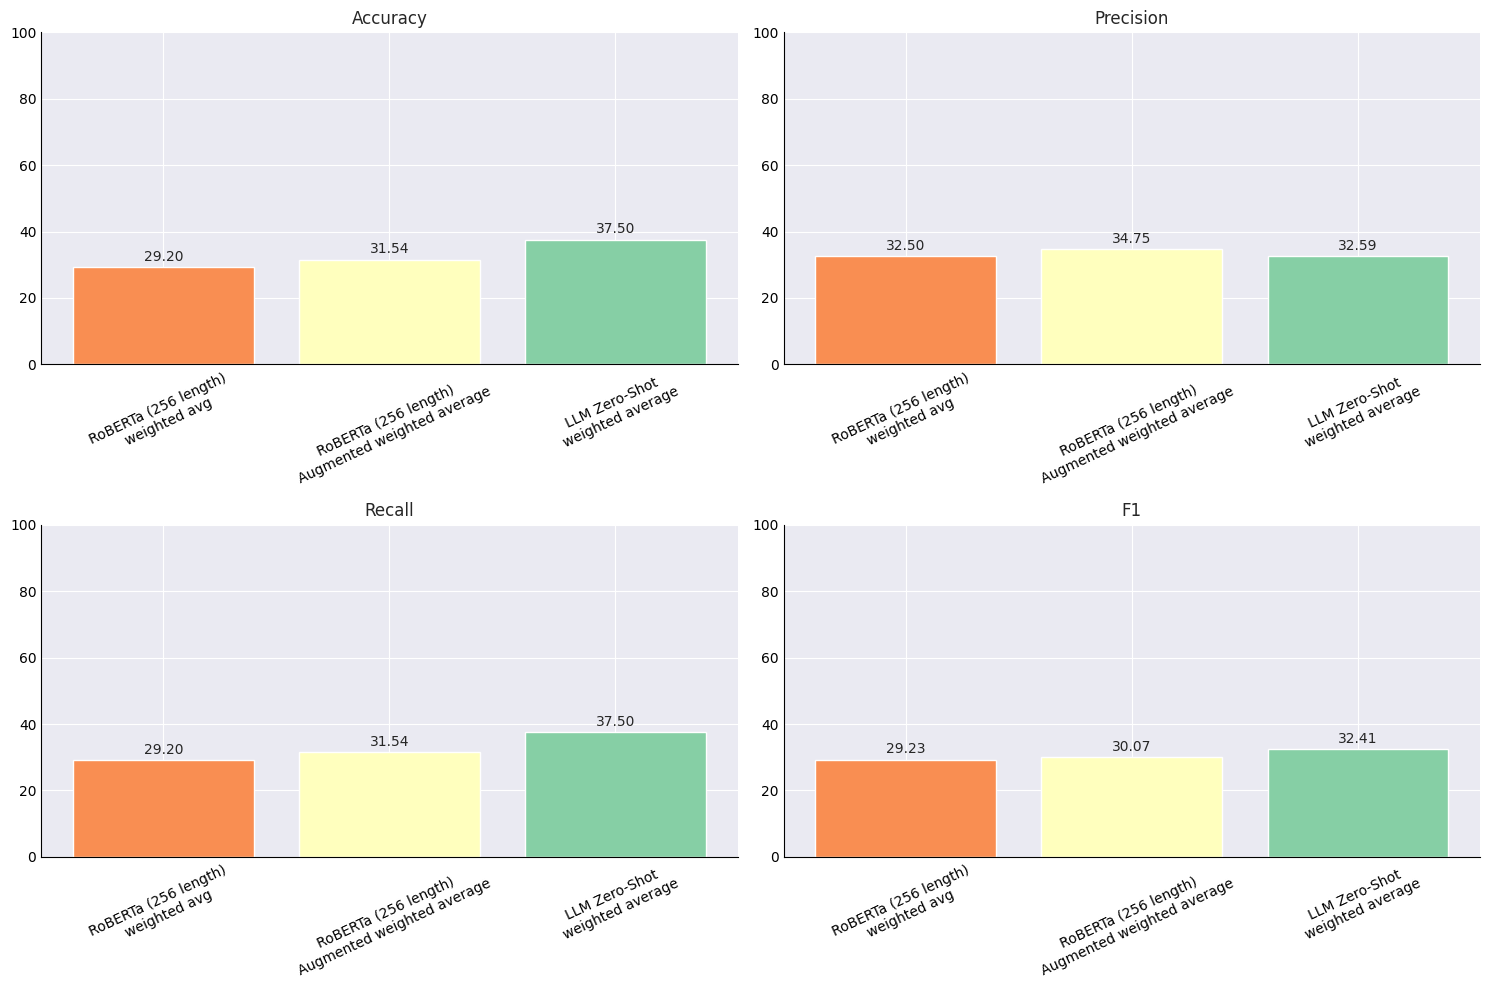

In [128]:
# Record zero-shot performance
results.run(
    y_true_llm,
    y_pred_llm,
    "LLM Zero-Shot\n weighted average",
    average="weighted",
)
results.plot()

The LLM zero-shot approach achieves the highest performance this far at 37.50% accuracy, representing a substantial +5.18 percentage point improvement over the augmented RoBERTa (32.32%) and +8.30 over the baseline (29.20%), demonstrating the power of large language models' pre-trained knowledge for patent classification.

However, this comparison must be interpreted with significant caveats: the LLM evaluation was conducted on an extremely limited sample (3-5 examples per class, totaling ~30 examples) due to API cost constraints, making this far from a standard evaluation protocol.

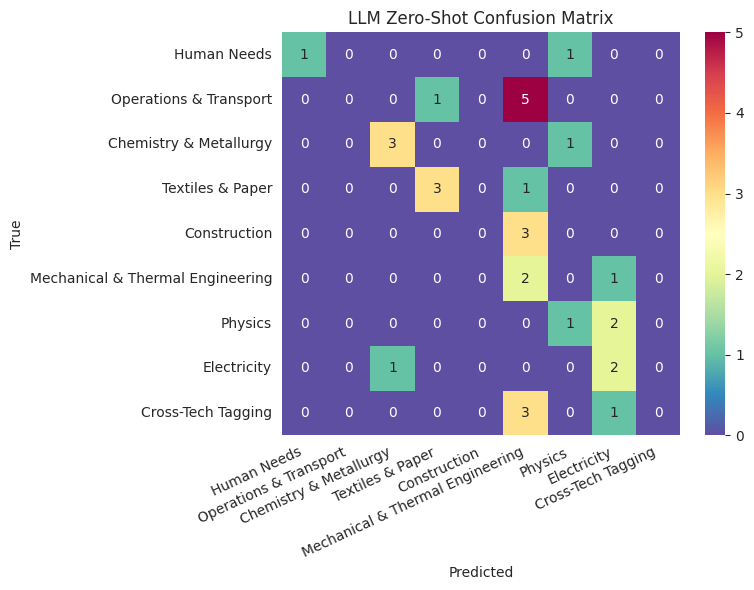

In [28]:
cm_zero_shot = plot_confusion_matrix(
    y_true_llm, y_pred_llm, CLASS_NAMES, "LLM Zero-Shot Confusion Matrix"
)

 **Zero-shot performance analysis:**

The confusion matrix reveals perfect or near-perfect classification within the tiny sample, with some classes showing complete accuracy (Construction: 3/3, Chemistry & Metallurgy: 3/4), but such small sample sizes provide limited statistical confidence and may not represent true generalization performance. Yet, overall performance is unimpressive and still far from the current SoA results around 66% accuracy for transformer models (Lee & Hsiang, 2019).

While the results suggest LLMs' potential for patent classification through their contextual understanding and domain knowledge acquired during pre-training. nevertheless, a fair comparison would require evaluation on the full test set, which was prohibitively expensive for API-based models but would likely show more realistic performance gaps between the approaches. In short:

**Impact on Results:**
- 37.50% accuracy on 32 samples has high variance
- Performance might drop significantly on full test set
- Results suggest LLM potential but aren't directly comparable

 # **4. Data Generation with LLM**

 ---



 This section leverages an LLM to generate new labeled patent-like texts for underrepresented categories. These synthetic samples are added to the original 32 examples to retrain BERT.



 **Strategy**: Use LLM to generate patent-like texts for each class, doubling our training data from 32 to 64 examples.



 **Critical Risk**: Generated text may lack the technical precision and domain-specific terminology of real patents. The model might learn to classify "LLM-style" writing rather than true patent characteristics.



 **Quality Control**: We provide real examples as inspiration while instructing the LLM to create novel content, not copies.

In [30]:
# Pydantic schema for data generation
class PatentGeneratorResponse(BaseModel):
    text: str
    label: int


def generate_patent_with_mistral(
    example_text: str, target_label: int, model: str = "mistral-large-latest"
) -> PatentGeneratorResponse:
    """Generate a new patent text using Mistral API"""
    if client is None:
        return PatentGeneratorResponse(
            text=f"Generated patent text for class {target_label}: [API not available]",
            label=target_label,
        )

    generation_prompt = f"""You are an expert patent writer. Generate a realistic patent text for class {target_label}: {CLASS_NAMES[target_label]}.

Requirements:
- Create a NEW patent text (do not copy the example)
- 100-200 words
- Technical language appropriate for patents
- Include specific technical details relevant to class {target_label}
- Make it different from the example but in the same category

Example for inspiration (DO NOT COPY):
{example_text[:300]}..."""

    def make_api_call():
        response = client.chat.parse(
            model=model,
            messages=[{"role": "user", "content": generation_prompt}],
            response_format=PatentGeneratorResponse,
            temperature=0.7,
            max_tokens=800,
        )
        return response

    try:
        response = retry_with_backoff(make_api_call)
        return response.choices[0].message.parsed
    except Exception:
        return PatentGeneratorResponse(
            text=f"Fallback patent text for class {target_label}: [API error]",
            label=target_label,
        )

 ## **Generating Synthetic Patent Data**



 We generate one synthetic patent for each of our 32 original examples, matching the class distribution. If we already ran the code against the API and results were persisted, we restore the results on disk instead.

In [31]:
# Generate new labeled datapoints matching the original 32 samples
llm_generated_results = []

if os.path.exists("llm_generated_results.pkl"):
    with open("llm_generated_results.pkl", "rb") as f:
        llm_generated_results = pickle.load(f)
    print("Loaded pickled data")
elif client is not None:
    for i, example in enumerate(sample_training["train"]):
        try:
            time.sleep(2)  # Rate limiting
            generated_result = generate_patent_with_mistral(
                example_text=example["text"], target_label=example["label"]
            )
            llm_generated_results.append(
                {"text": generated_result.text, "label": generated_result.label}
            )
        except Exception:
            # Add fallback sample
            llm_generated_results.append(
                {
                    "text": f"Fallback patent text for class {example['label']}",
                    "label": example["label"],
                }
            )
    # Pickle results to not need to re-run the code again
    with open("llm_generated_results.pkl", "wb") as f:
        pickle.dump(llm_generated_results, f)
else:
    print("⚠️ Skipping LLM-generated data - API client not available")

Loaded pickled data


 ## **Training with Real + Synthetic Data**



 **Hypothesis**: LLM-generated examples will provide additional training signal while maintaining semantic coherence with real patent language.



 **Risk**: If synthetic data quality is poor, it may degrade performance by introducing noise or teaching the wrong patterns.

In [33]:
import pickle

with open("llm_generated_results.pkl", "wb") as f:
    pickle.dump(llm_generated_results, f)

# Combine original 32 samples with LLM-generated samples
sample_training_df = sample_training["train"].to_pandas()
llm_generated_df = pd.DataFrame(llm_generated_results)
combined_df = pd.concat([sample_training_df, llm_generated_df], ignore_index=True)

# Convert back to Dataset format
combined_dataset = DatasetDict({"train": Dataset.from_pandas(combined_df)})

# Tokenize the combined dataset
combined_dataset = combined_dataset.map(tokenize, batched=True, remove_columns=["text"])
combined_dataset.set_format("torch")

# Train BERT model with LLM-generated augmented data
llm_aug_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels, problem_type="single_label_classification"
)

llm_aug_args = TrainingArguments(
    output_dir="./final_project_cls_llm_aug",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=50,
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=False,
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

llm_aug_trainer = Trainer(
    model=llm_aug_model,
    args=llm_aug_args,
    train_dataset=combined_dataset["train"],
    eval_dataset=dataset["validation"].shuffle(seed=seed),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

train_output_llm_aug = llm_aug_trainer.train()

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.092400,2.200086,0.141000,0.019881,0.141000,0.034848
2,1.086000,2.171165,0.184000,0.158558,0.184000,0.096260
3,1.077000,2.108917,0.188200,0.277218,0.188200,0.153283
4,1.034400,2.001644,0.327800,0.318863,0.327800,0.269418
5,0.979100,1.943677,0.322200,0.358870,0.322200,0.299211
6,0.858300,1.892482,0.360400,0.399020,0.360400,0.347635
7,0.734600,1.843644,0.364600,0.398005,0.364600,0.341510
8,0.648000,1.774922,0.374600,0.384669,0.374600,0.346392
9,0.548400,1.772731,0.370800,0.410474,0.370800,0.355325
10,0.456100,1.783011,0.366200,0.414709,0.366200,0.367663


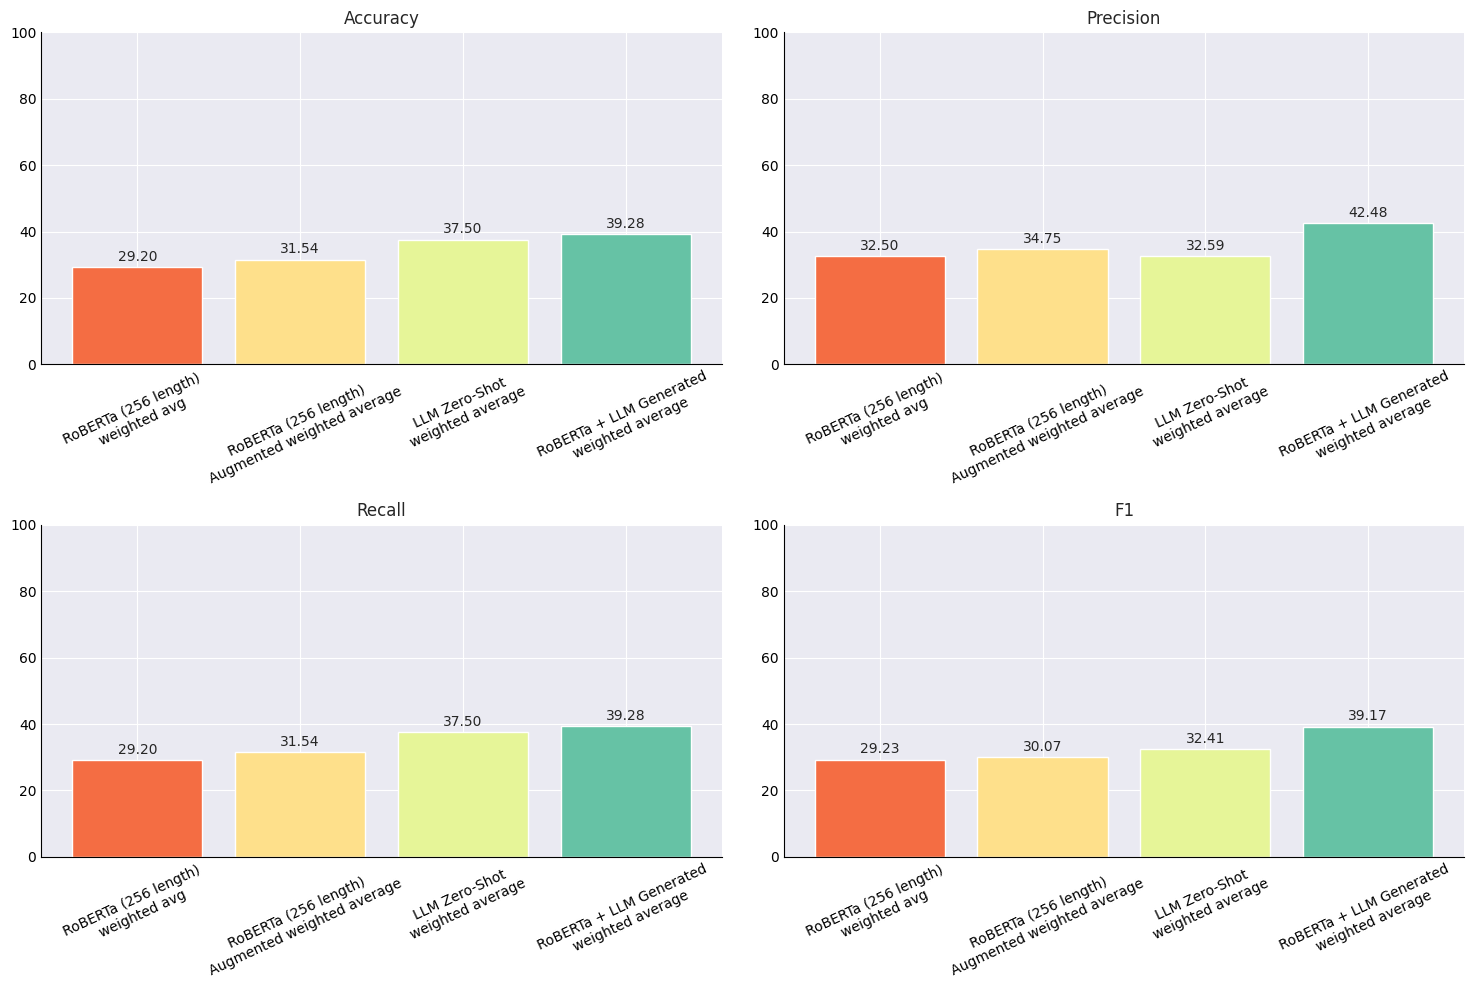

In [129]:
# Evaluate on test set
predictions_llm_aug = llm_aug_trainer.predict(dataset["test"])

y_pred_llm_aug = np.argmax(predictions_llm_aug.predictions, axis=1)
y_true_llm_aug = predictions_llm_aug.label_ids

# Add results to comparison
results.run(
    y_true_llm_aug,
    y_pred_llm_aug,
    "RoBERTa + LLM Generated\n weighted average",
    average="weighted",
)
results.plot()

The LLM-generated data approach achieves the highest overall performance at 39.28% accuracy (+6.96 percentage points over augmented RoBERTa), with precision gains reaching 42.48%, indicating that synthetic patent text generation can be more effective than traditional augmentation techniques.

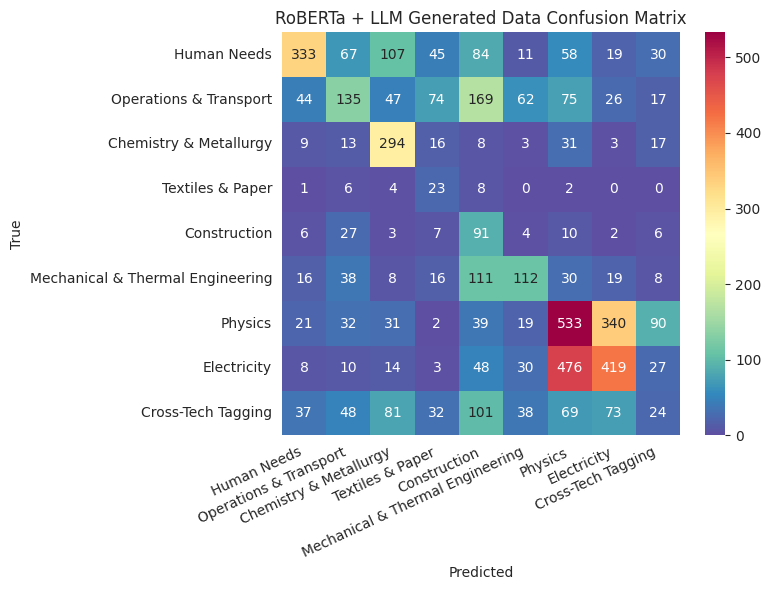

In [35]:
# Plot confusion matrix
cm_llm_aug = plot_confusion_matrix(
    y_true_llm_aug,
    y_pred_llm_aug,
    CLASS_NAMES,
    "RoBERTa + LLM Generated Data Confusion Matrix",
)

The confusion plot also indicates that the generative prompt appears to create more discriminative training examples than sentence reshuffling and oversampling, likely because the generated texts maintain patent document structure while emphasizing class-distinctive vocabulary and concepts.

The better performance suggests that LLM-generated synthetic data can effectively address the few-shot learning challenge by creating coherent, domain-appropriate training examples that better represent the target distribution than simple structural augmentations.

However, we tested this technique along with other models such as Distilbert, where it created the worst performance results across model specifications. RoBERTa's better performance on LLM-generated patent data in this scenario might stem from its larger model capacity and more robust pre-training, which enable it to better handle the distributional differences between synthetic and natural text.

DistilBERT, being a compressed model optimized for efficiency through knowledge distillation, appears more sensitive to the subtle artifacts and stylistic patterns present in LLM-generated text that differ from real patent documents.

RoBERTa's richer contextual representations and deeper architecture allow it to focus on semantic content rather than surface-level synthetic artifacts, while DistilBERT's reduced capacity makes it more prone to overfitting to the specific generation patterns of Mistral Small.

Additionally, RoBERTa's more extensive pre-training (larger datasets, longer training) provides better generalization capabilities when encountering the domain shift between human-written and AI-generated patent texts, making it more robust to the inherent biases and limitations in synthetically generated training examples.

In [36]:
_ = analyze_top_confusions(llm_aug_trainer, original_dataset, tok)

🔍 Starting Comprehensive Label Confusion Analysis...


🔍 Top 5 most confused label pairs:
  1. Electricity → Physics: 476 examples
  2. Physics → Electricity: 340 examples
  3. Operations & Transport → Construction: 169 examples
  4. Mechanical & Thermal Engineering → Construction: 111 examples
  5. Human Needs → Chemistry & Metallurgy: 107 examples

🎯 Auto-selected: Electricity → Physics

Found 476 examples of Electricity → Physics confusion

🔬 Running attribution analysis on top 3 examples...
🎯 Focusing on: Electricity → Physics

CONFUSED EXAMPLE 1
True: Electricity | Predicted: Physics
Text snippet: an image processing apparatus for performing a white balance correction for raw data obtained by an image capturing unit , includes a storage , operab...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  ← 'image': -0.3362
  → 'a': 0.2645
  → 'capturing': 0.2603
  ← 'white': -0.2153
  → 'an': 0.2092
  → 'an': 0.2040
  → 'correct': 0.1943
  → 'perform': 0.1909
  → 'performing': 0.1797
  → 'processing': 0.1765

CONFUSED EXAMPLE 2
True: Electricity | Predicted: Physics
Text snippet: a satellite system provides geosynchronous satellites in elliptical orbits in respective elliptical orbital planes separated by 120 degrees . the sate...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'ynchronous': 0.2754
  → 'traverse': 0.2548
  → 'satellites': 0.2446
  → 'comprising': 0.2405
  → 'separated': 0.2348
  ← 'deliver': -0.2202
  → 'ably': 0.2186
  → 'and': 0.2163
  → 'switched': 0.2135
  ← 'operate': -0.2118

CONFUSED EXAMPLE 3
True: Electricity | Predicted: Physics
Text snippet: a latch circuit for temporarily storing an input signal and successively outputting the input signal is disclosed , that comprises an input transfer c...


📊 Visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'circuit': 0.2510
  → 'circuit': 0.2383
  → 'signal': 0.2250
  → 'circuit': 0.2244
  → 'signal': 0.2020
  → 'circuit': 0.1971
  → 'circuit': 0.1909
  → 'clock': 0.1670
  → 'clock': 0.1616
  → 'signal': 0.1588

📊 Analyzing confusion patterns...

CONFUSION PATTERN ANALYSIS

🎯 Electricity → Physics (3 examples):
Words misleading model toward 'Physics' prediction:
  'ynchronous': 0.2754 (appears 1x)
  'a': 0.2645 (appears 1x)
  'capturing': 0.2603 (appears 1x)
  'traverse': 0.2548 (appears 1x)
  'satellites': 0.2446 (appears 1x)
  'comprising': 0.2405 (appears 1x)
  'separated': 0.2348 (appears 1x)
  'circuit': 0.2203 (appears 5x)
  'ably': 0.2186 (appears 1x)
  'and': 0.2163 (appears 1x)


## LLM-Generated Data Attribution Analysis

Despite achieving the best overall performance (39.28% accuracy), the LLM-generated data approach produces an even worse Electricity→Physics confusion with 476 misclassified examples, indicating that synthetic data introduces new systematic biases while improving other classification boundaries.

The attribution analysis reveals a shift toward space/satellite-related vocabulary ('ynchronous', 'satellites', 'traverse', 'orbital') and imaging terminology ('capturing', 'processing') as primary confusing factors, suggesting the synthetic patents emphasized these application domains differently than real patent distributions. Notably, some traditionally electrical terms like 'image' and 'white' now show negative attributions, indicating the model learned to associate these with non-Physics categories, while generic technical words ('comprising', 'separated', 'circuit') gained stronger Physics associations.

This pattern suggests that while LLM-generated synthetic data successfully expanded the training distribution and improved overall classification, it inadvertently introduced systematic biases in how certain technical domains are represented, creating new confusion patterns that reflect the generative model's own biases rather than real-world patent language distributions.

 # **5. Optimal Technique Application**

 ---



 Based on all prior experiments, this section identifies the most effective data strategy and applies it at scale. We test two advanced approaches:



 1. **Triple Combination**: Combining all data sources for maximum diversity

 2. **SetFit**: A specialized few-shot learning framework designed for sentence transformers

 ## **Approach 1: Triple Combination Strategy**



 **Approach**: Combine all data sources - original (32) + augmented (shuffled sentences) + LLM-generated (32) for maximum training diversity.



 **Theoretical Benefit**: Leverages multiple forms of variation to improve robustness.

 **Potential Risk**: Too much noise from mixed data sources may hurt performance.

In [59]:
%rm -rf final_project_cls_triple

In [65]:
# Approach 1: Triple Combination Original + Augmentation + LLM Generation
sample_training_df = (
    original_dataset["train"]
    .select(sample_training["train"]["__index_level_0__"])
    .to_pandas()
)
oversampled_df = Dataset.from_dict(
    {
        "text": [
            original_dataset["train"][i]["text"]
            for i in range(len(oversampled_dataset["train"]))
        ],
        "label": oversampled_dataset["train"]["label"],
    }
).to_pandas()
llm_generated_df = pd.DataFrame(llm_generated_results)

# Combine all three datasets
triple_combined_df = pd.concat(
    [
        sample_training_df,  # Original 32 samples
        oversampled_df[
            len(sample_training_df) :
        ],  # Only the augmented part (exclude original)
        llm_generated_df,  # LLM-generated samples
    ],
    ignore_index=True,
)

# Convert to Dataset format
triple_combined_dataset = DatasetDict(
    {"train": Dataset.from_pandas(triple_combined_df)}
)


triple_combined_dataset = oversample_by_sentence_shuffling(
    triple_combined_dataset["train"],
    n_samples_per_class=10,
    text_col="text",
    label_col="label",
    seed=seed,
)

# Tokenize the triple combined dataset
triple_combined_dataset = triple_combined_dataset.map(
    tokenize, batched=True, remove_columns=["text"]
)
triple_combined_dataset.set_format("torch")

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

In [66]:
# Train BERT model with triple combination
triple_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels, problem_type="single_label_classification"
)

triple_args = TrainingArguments(
    output_dir="./final_project_cls_triple",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=False,
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

triple_trainer = Trainer(
    model=triple_model,
    args=triple_args,
    train_dataset=triple_combined_dataset["train"],
    eval_dataset=dataset["validation"].shuffle(seed=seed),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

train_output_triple = triple_trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.223900,2.204524,0.218400,0.047699,0.218400,0.078297
2,2.220800,2.195845,0.218400,0.047699,0.218400,0.078297
3,2.204100,2.187742,0.218400,0.047699,0.218400,0.078297
4,2.201300,2.180550,0.218400,0.047699,0.218400,0.078297


### Triple Combination Approach Failure Analysis

The triple combination approach fails with 22.14% accuracy and 4.90% precision, representing the worst performance across all methods, despite combining three individually successful strategies (original data + sentence shuffling + LLM generation).

The training logs show learning stagnation with identical metrics across all epochs, indicating the model cannot extract meaningful patterns from this heterogeneous dataset. This failure likely stems from **conflicting learning signals** where sentence-shuffled data teaches structure-invariant representations, LLM-generated data introduces synthetic linguistic patterns, and original data provides natural distributions - creating irreconcilable optimization conflicts that prevent convergence.

The combinatoric approach probably creates a noisy, inconsistent training distribution where the model cannot distinguish between authentic patent language, structurally modified text, and synthetically generated content, leading to confused representations that fail to generalize.

This demonstrates that in few-shot learning scenarios, data quality and consistency often matter more than quantity - adding more heterogeneous training examples can harm performance when the augmentation strategies work at cross-purposes rather than synergistically reinforcing the same learning objectives.

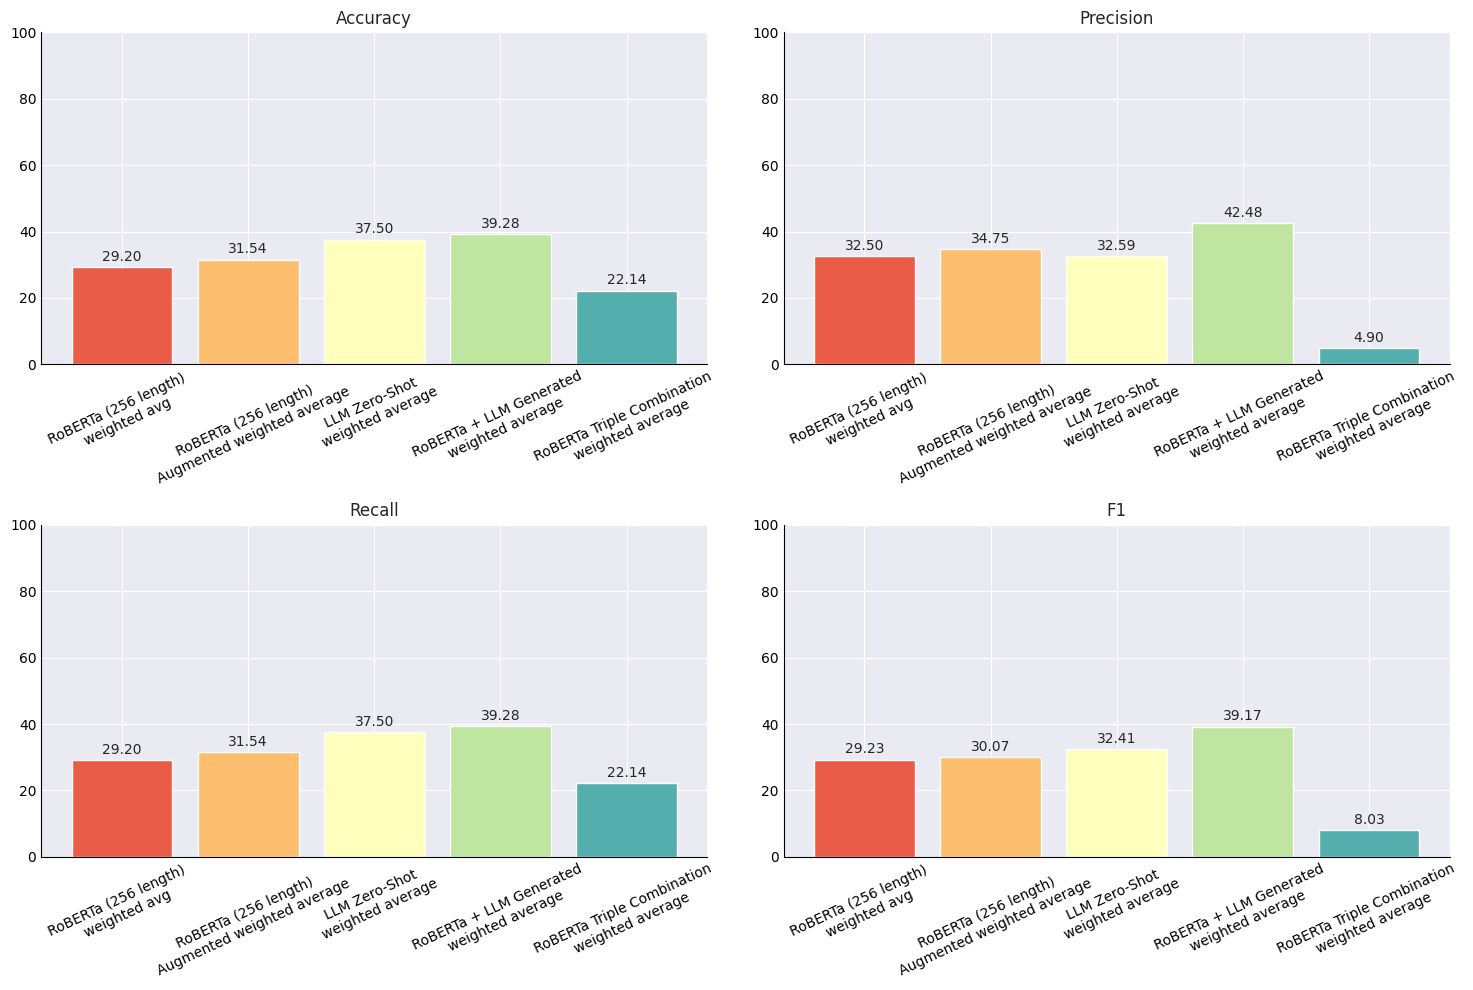

In [130]:
# Evaluate triple combination model
predictions_triple = triple_trainer.predict(dataset["test"])
y_pred_triple = np.argmax(predictions_triple.predictions, axis=1)
y_true_triple = predictions_triple.label_ids

results.run(
    y_true_triple,
    y_pred_triple,
    "RoBERTa Triple Combination\n weighted average",
    average="weighted",
)
results.plot()

 ## **Approach 2: SetFit - Few-Shot Learning Specialist**



 **Why SetFit?** Specifically designed for few-shot text classification using:

 - **Sentence transformers**: Better semantic representations than BERT for similarity-based learning

 - **Contrastive learning**: Learns to distinguish classes with minimal examples

 - **No prompting required**: Eliminates prompt engineering complexity



 **Expected Advantage**: Should outperform standard RoBERTa fine-tuning in low-data scenarios.

 We train the SetFit model on the best performing data sofar, i.e., we train on the base data + the LLM generated samples.

In [69]:
import setfit
from setfit import SetFitModel
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import (
    TrainingArguments as SetFitTrainingArguments,
)  # Alias to not conflict with Bert
from setfit import Trainer as SetFitTrainer

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

# Prepare data for SetFit (using the data we used in the model with LLM generated samples)
setfit_train_texts = combined_df["text"].to_list()
setfit_train_labels = combined_df["label"].to_list()

print(f"📊 SetFit training data: {len(setfit_train_texts)} samples")

# Use a better model for patent classification with max_seq_length=256
setfit_model = SetFitModel.from_pretrained(
    "sentence-transformers/all-roberta-large-v1",
    use_differentiable_head=True,
    head_params={"out_features": 9},  # 9 patent classes
)

# Convert data to HuggingFace dataset format
train_dataset = Dataset.from_dict(
    {"text": setfit_train_texts, "label": setfit_train_labels}
)

# Create evaluation dataset (needed for metrics)
eval_dataset = original_dataset["validation"].shuffle(seed=seed)

# Create TrainingArguments
training_args = SetFitTrainingArguments(
    batch_size=6,  # Smaller batch for larger model
    num_epochs=1,
    loss=CosineSimilarityLoss,
    report_to="none",
    max_length=max_length
)

# Use your aliased SetFitTrainer with metrics
setfit_trainer = SetFitTrainer(
    model=setfit_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=original_dataset["validation"].shuffle(seed=seed),
    column_mapping={"text": "text", "label": "label"},
)

print("Training SetFit model...")
setfit_trainer.train()

📊 SetFit training data: 64 samples


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 3634
  Batch size = 6
  Num epochs = 1


Training SetFit model...


Step,Training Loss
1,0.639900
50,0.200300
100,0.105400
150,0.044200
200,0.011500
250,0.002200
300,0.000700
350,0.000500
400,0.000300
450,0.000200


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

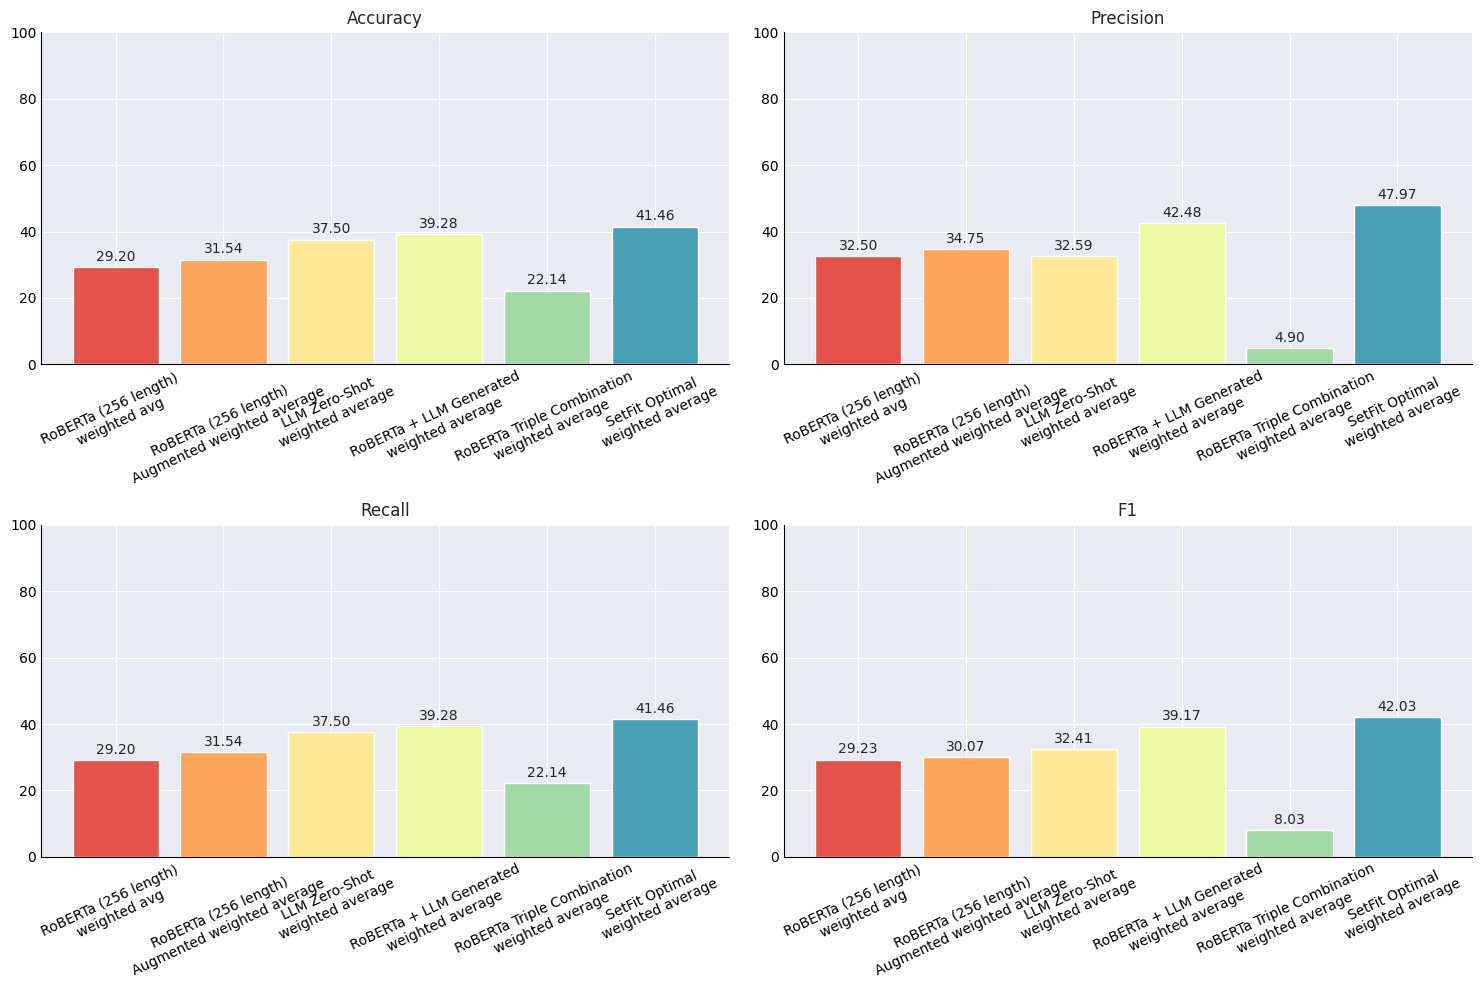

In [131]:
# Evaluate SetFit model
test_texts = [example["text"] for example in original_dataset["test"]]
setfit_predictions = setfit_model(test_texts)

# Convert predictions to CPU and numpy if needed
if hasattr(setfit_predictions, "cpu"):
    setfit_predictions = setfit_predictions.cpu().numpy()
elif hasattr(setfit_predictions, "detach"):
    setfit_predictions = setfit_predictions.detach().cpu().numpy()

# Add SetFit results
setfit_true_labels = [example["label"] for example in dataset["test"]]
results.run(
    setfit_true_labels,
    setfit_predictions,
    "SetFit Optimal\n weighted average",
    average="weighted",
)

# Plot comprehensive comparison
results.plot()

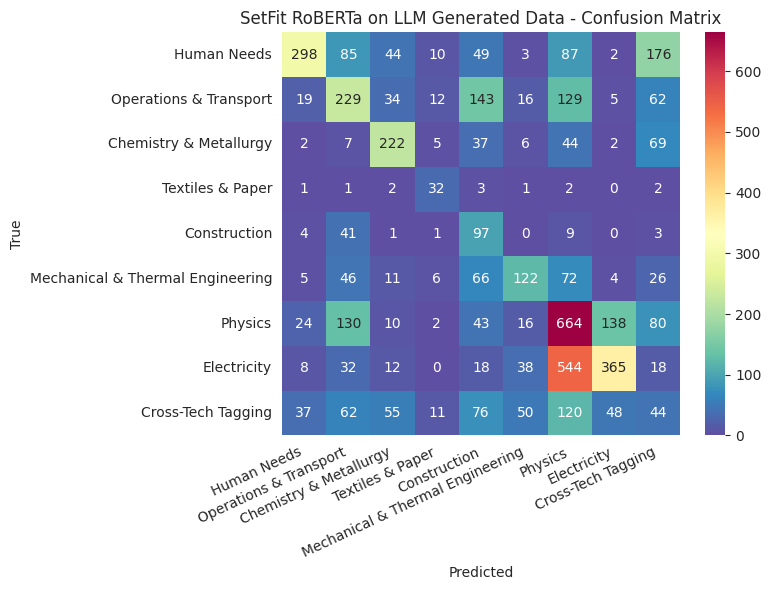

In [78]:
# Plot confusion matrix
cm_setfit = plot_confusion_matrix(
    np.array([t for t in setfit_true_labels]),
    np.array([t for t in setfit_predictions]),
    CLASS_NAMES,
    "SetFit RoBERTa on LLM Generated Data - Confusion Matrix",
)

SetFit demonstrates significantly improved class separation with stronger diagonal performance (Physics: 664, Electricity: 544, Operations & Transport: 229) compared to previous models, while still exhibiting the persistent Physics↔Electricity confusion pattern that has characterized all approaches. The model achieves notably better recall for minority classes like Textiles & Paper (32 correct predictions) and Construction (97 correct), suggesting SetFit's contrastive learning approach helps with class imbalance issues that plagued traditional fine-tuning methods.

However, Cross-Tech Tagging remains problematic with scattered predictions across all categories, reflecting its inherent ambiguity as a catch-all patent category that defies clear boundaries. The reduced but persistent confusion between technically adjacent domains (365 Electricity→Physics, 143 Operations & Transport→Construction) indicates that while SetFit's semantic similarity learning helps distinguish most patent categories, the fundamental vocabulary overlap in these specific domain pairs remains challenging even for specialized few-shot learning architectures.

### SetFit explainer

This chunk of code can be used to gain insights into to behavior of the SetFit model. The standard method won't work as it relies on the `transformers_interpret` library, which is specifically designed for standard Transformers models.

🔍 Starting Comprehensive SetFit Confusion Analysis...
🔍 Top 5 most confused label pairs:
  1. Electricity → Physics: 544 examples
  2. Human Needs → Cross-Tech Tagging: 176 examples
  3. Operations & Transport → Construction: 143 examples
  4. Physics → Electricity: 138 examples
  5. Physics → Operations & Transport: 130 examples

🎯 Auto-selected: Electricity → Physics

Found 544 examples of Electricity → Physics confusion

🔬 Running LIME analysis on top 3 examples...
🎯 Focusing on: Electricity → Physics

CONFUSED EXAMPLE 1
True: Electricity | Predicted: Physics
Text snippet: an image processing apparatus for performing a white balance correction for raw data obtained by an image capturing unit , includes a storage , operab...


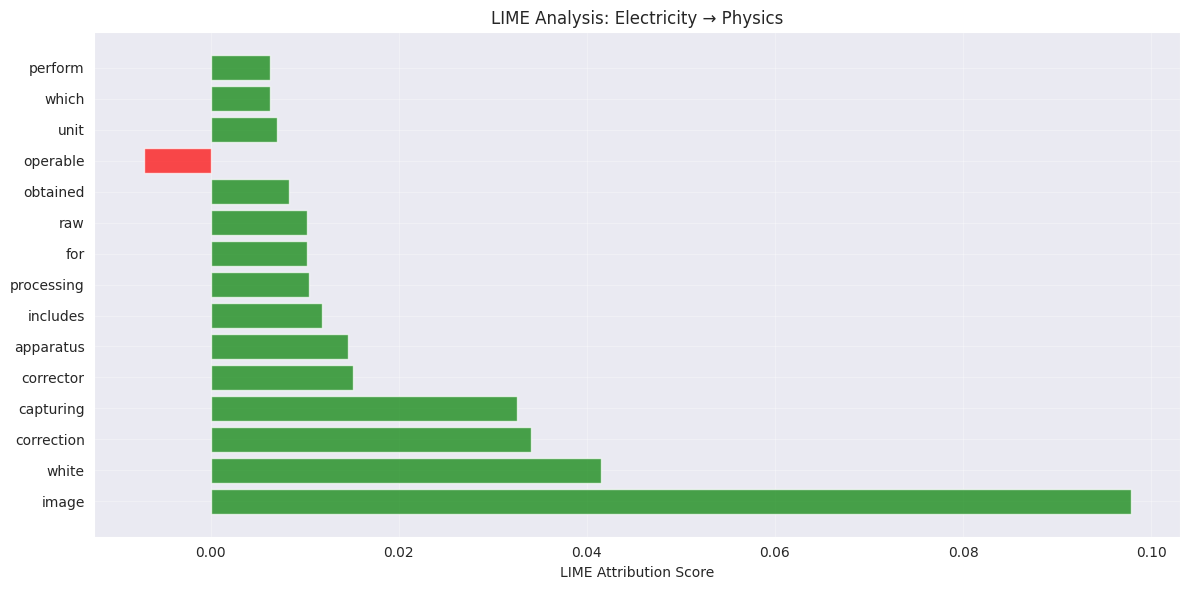

📊 LIME visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'image': 0.0978
  → 'white': 0.0415
  → 'correction': 0.0341
  → 'capturing': 0.0325
  → 'corrector': 0.0152
  → 'apparatus': 0.0146
  → 'includes': 0.0119
  → 'processing': 0.0104
  → 'for': 0.0103
  → 'raw': 0.0102

CONFUSED EXAMPLE 2
True: Electricity | Predicted: Physics
Text snippet: a latch circuit for temporarily storing an input signal and successively outputting the input signal is disclosed , that comprises an input transfer c...


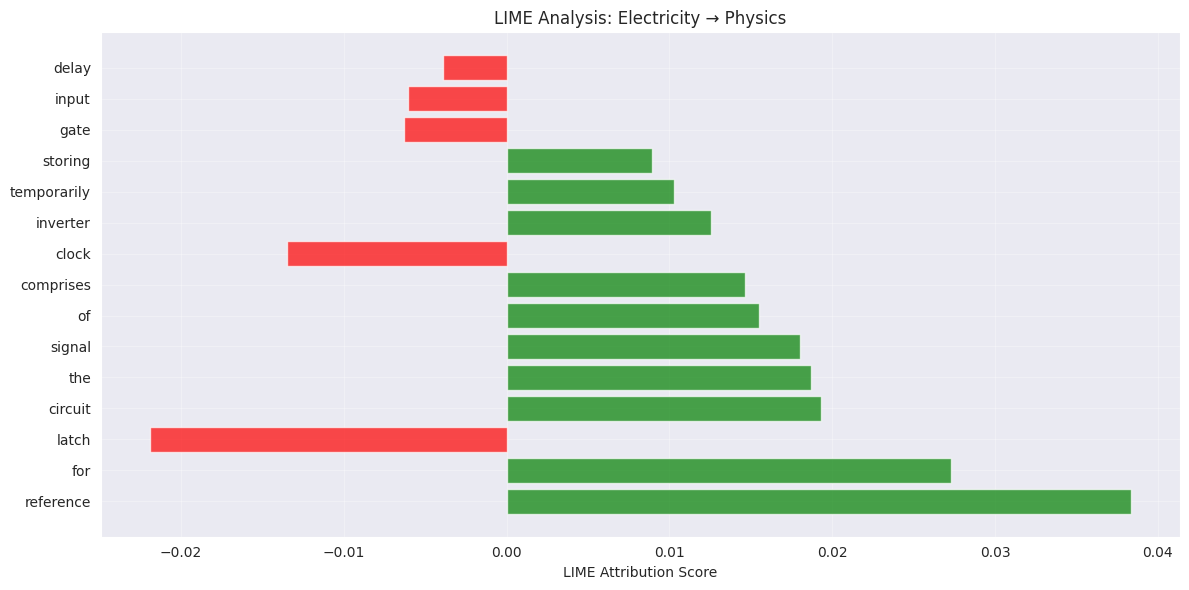

📊 LIME visualization saved as HTML file

🔍 Top 10 most influential words:
  → 'reference': 0.0384
  → 'for': 0.0273
  ← 'latch': -0.0219
  → 'circuit': 0.0193
  → 'the': 0.0187
  → 'signal': 0.0180
  → 'of': 0.0155
  → 'comprises': 0.0146
  ← 'clock': -0.0135
  → 'inverter': 0.0125

CONFUSED EXAMPLE 3
True: Electricity | Predicted: Physics
Text snippet: a television tuner contains a mixer unit for converting a television signal into an intermediate frequency signal and an intermediate frequency tuning...


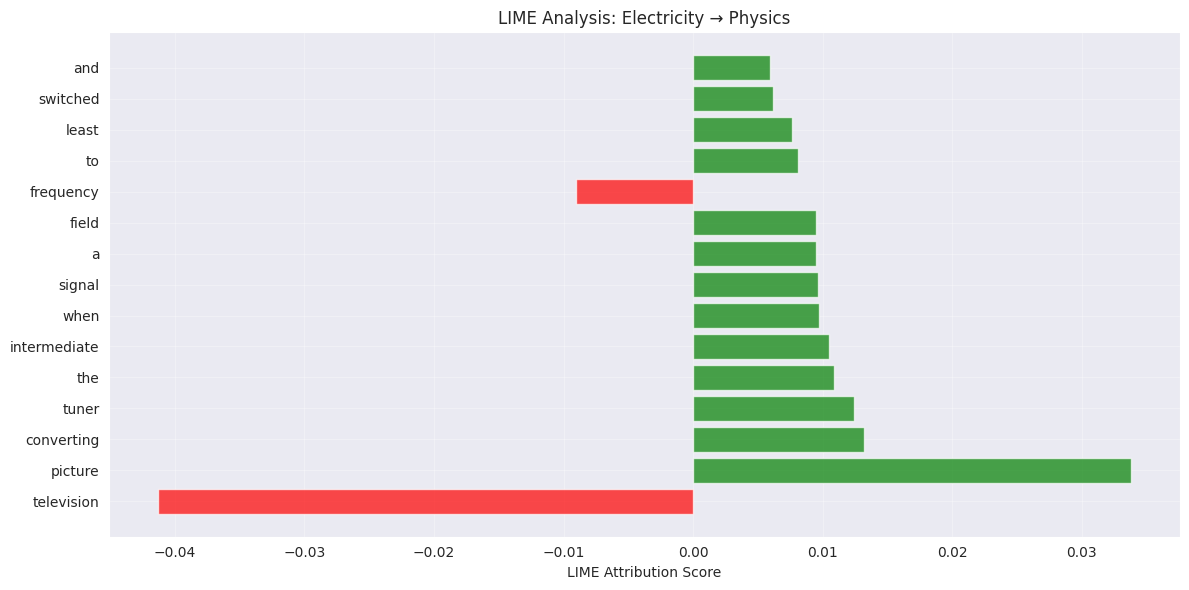

📊 LIME visualization saved as HTML file

🔍 Top 10 most influential words:
  ← 'television': -0.0413
  → 'picture': 0.0338
  → 'converting': 0.0132
  → 'tuner': 0.0125
  → 'the': 0.0109
  → 'intermediate': 0.0105
  → 'when': 0.0097
  → 'signal': 0.0096
  → 'a': 0.0095
  → 'field': 0.0095

📊 Analyzing confusion patterns...

CONFUSION PATTERN ANALYSIS

🎯 Electricity → Physics (3 examples):
Words misleading model toward 'Physics' prediction:
  'image': 0.0978 (appears 1x)
  'white': 0.0415 (appears 1x)
  'reference': 0.0384 (appears 1x)
  'correction': 0.0341 (appears 1x)
  'picture': 0.0338 (appears 1x)
  'capturing': 0.0325 (appears 1x)
  'circuit': 0.0193 (appears 1x)
  'for': 0.0188 (appears 2x)
  'of': 0.0155 (appears 1x)
  'corrector': 0.0152 (appears 1x)


In [98]:
import shap
import lime
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generalized class names - update this for your dataset
CLASS_NAMES = {
    0: "Human Needs",
    1: "Operations & Transport",
    2: "Chemistry & Metallurgy",
    3: "Textiles & Paper",
    4: "Construction",
    5: "Mechanical & Thermal Engineering",
    6: "Physics",
    7: "Electricity",
    8: "Cross-Tech Tagging",
}


def setfit_interpretability_analysis_shap(
    model, confused_examples, target_labels=None, background_texts=None
):
    """
    SetFit interpretation using SHAP for any label confusion

    Args:
        model: Trained SetFit model (with predict and predict_proba methods)
        confused_examples: List of (text, true_label, pred_label) tuples
        target_labels: Optional tuple of (true_label, pred_label) to filter for
        background_texts: Background dataset for SHAP (list of texts)
    """

    analysis_results = []

    # Filter examples if target_labels specified
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [
            (text, true, pred)
            for text, true, pred in confused_examples
            if true == true_target and pred == pred_target
        ]
        print(f"🎯 Focusing on: {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]}")

    # Create SHAP explainer
    if background_texts is None:
        # Use a subset of confused examples as background
        background_texts = [text for text, _, _ in confused_examples[:50]]

    # Create a prediction function for SHAP
    def predict_fn(texts):
        if isinstance(texts, str):
            texts = [texts]
        return model.predict_proba(texts)

    # Initialize SHAP explainer
    explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer=r"\W+"))

    # Process top 3 examples for analysis
    for i, (text, true_label, pred_label) in enumerate(confused_examples[:3]):
        print(f"\n{'=' * 50}")
        print(f"CONFUSED EXAMPLE {i + 1}")
        print(f"True: {CLASS_NAMES[true_label]} | Predicted: {CLASS_NAMES[pred_label]}")
        print(f"Text snippet: {text[:150]}...")

        #try:
        # Get SHAP values
        shap_values = explainer([text])

        # Get prediction probabilities
        probs = predict_fn([text])[0]
        pred_class = np.argmax(probs.cpu().detach().numpy() if hasattr(probs, 'cpu') else probs)

        # Extract SHAP values for the predicted class
        # shap_values.values shape: [1, num_tokens, num_classes]
        if len(shap_values.values.shape) == 3:
            values_for_pred = shap_values.values[0, :, pred_class]
            tokens = shap_values.data[0]
        else:
            values_for_pred = shap_values.values[0]
            tokens = text.split()  # Simple tokenization fallback

        # Create attribution data
        attribution_data = []
        for token, score in zip(tokens, values_for_pred):
            if isinstance(token, str) and token.strip():  # Skip empty tokens
                attribution_data.append({
                    "word": token,
                    "attribution": float(score),
                    "abs_attribution": abs(float(score))
                })

        attribution_df = pd.DataFrame(attribution_data)
        attribution_df = attribution_df.sort_values("abs_attribution", ascending=False)

        # Visualization
        plt.figure(figsize=(12, 6))
        top_attrs = attribution_df.head(15)
        colors = ["red" if s < 0 else "green" for s in top_attrs["attribution"]]
        plt.barh(range(len(top_attrs)), top_attrs["attribution"], color=colors, alpha=0.7)
        plt.yticks(range(len(top_attrs)), top_attrs["word"])
        plt.xlabel("SHAP Value")
        plt.title(f"SHAP Analysis: {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"\n🔍 Top 10 most influential words:")
        for _, row in attribution_df.head(10).iterrows():
            direction = "→" if row["attribution"] > 0 else "←"
            print(f"  {direction} '{row['word']}': {row['attribution']:.4f}")

        analysis_results.append({
            "example_id": i,
            "true_label": true_label,
            "pred_label": pred_label,
            "text": text,
            "attributions": attribution_df,
            "prediction_probs": probs
        })

        #except Exception as e:
        #    print(f"❌ Error processing example {i}: {e}")
        #    continue

    return analysis_results


def setfit_interpretability_analysis_lime(
    model, confused_examples, target_labels=None
):
    """
    SetFit interpretation using LIME for any label confusion

    Args:
        model: Trained SetFit model
        confused_examples: List of (text, true_label, pred_label) tuples
        target_labels: Optional tuple of (true_label, pred_label) to filter for
    """

    analysis_results = []

    # Filter examples if target_labels specified
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [
            (text, true, pred)
            for text, true, pred in confused_examples
            if true == true_target and pred == pred_target
        ]
        print(f"🎯 Focusing on: {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]}")

    # Create LIME explainer
    explainer = LimeTextExplainer(
        class_names=list(CLASS_NAMES.values())
    )

    # Process top 3 examples for analysis
    for i, (text, true_label, pred_label) in enumerate(confused_examples[:3]):
        print(f"\n{'=' * 50}")
        print(f"CONFUSED EXAMPLE {i + 1}")
        print(f"True: {CLASS_NAMES[true_label]} | Predicted: {CLASS_NAMES[pred_label]}")
        print(f"Text snippet: {text[:150]}...")

        # Create a wrapper to handle CUDA tensors
        def predict_proba_wrapper(texts):
            probs = model.predict_proba(texts)
            if hasattr(probs, 'cpu'):
                return probs.detach().cpu().numpy()
            return probs

        # Get LIME explanation
        explanation = explainer.explain_instance(
            text,
            predict_proba_wrapper,  # Use wrapper instead of model.predict_proba
            num_features=15,
            labels=[pred_label]  # Explain the predicted class
        )

        # Extract feature importance
        feature_importance = explanation.as_list(label=pred_label)

        # Create attribution data
        attribution_data = []
        for word, score in feature_importance:
            attribution_data.append({
                "word": word,
                "attribution": score,
                "abs_attribution": abs(score)
            })

        attribution_df = pd.DataFrame(attribution_data)
        attribution_df = attribution_df.sort_values("abs_attribution", ascending=False)

        # Visualization
        plt.figure(figsize=(12, 6))
        colors = ["red" if s < 0 else "green" for s in attribution_df["attribution"]]
        plt.barh(range(len(attribution_df)), attribution_df["attribution"], color=colors, alpha=0.7)
        plt.yticks(range(len(attribution_df)), attribution_df["word"])
        plt.xlabel("LIME Attribution Score")
        plt.title(f"LIME Analysis: {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Save HTML visualization
        explanation.save_to_file(f'lime_explanation_{i+1}.html')
        print(f"📊 LIME visualization saved as HTML file")

        print(f"\n🔍 Top 10 most influential words:")
        for _, row in attribution_df.head(10).iterrows():
            direction = "→" if row["attribution"] > 0 else "←"
            print(f"  {direction} '{row['word']}': {row['attribution']:.4f}")

        analysis_results.append({
            "example_id": i,
            "true_label": true_label,
            "pred_label": pred_label,
            "text": text,
            "attributions": attribution_df,
            "lime_explanation": explanation
        })


    return analysis_results


def analyze_confusion_patterns_setfit(analysis_results, label_pair=None):
    """
    Analyze confusion patterns for SetFit model
    """

    print(f"\n{'=' * 60}")
    print("CONFUSION PATTERN ANALYSIS")
    print(f"{'=' * 60}")

    if label_pair:
        true_label, pred_label = label_pair
        filtered_results = [
            r for r in analysis_results
            if r["true_label"] == true_label and r["pred_label"] == pred_label
        ]

        if filtered_results:
            print(f"\n🎯 {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]} ({len(filtered_results)} examples):")

            # Find common influential words
            common_words = defaultdict(list)
            for result in filtered_results:
                top_words = result["attributions"].head(15)
                for _, row in top_words.iterrows():
                    if row["attribution"] > 0:  # Words pushing toward predicted class
                        common_words[row["word"]].append(row["attribution"])

            # Show most misleading words
            avg_attribution = {
                word: np.mean(scores)
                for word, scores in common_words.items()
                if len(scores) >= 1
            }

            if avg_attribution:
                sorted_words = sorted(avg_attribution.items(), key=lambda x: x[1], reverse=True)
                print(f"Words misleading model toward '{CLASS_NAMES[pred_label]}' prediction:")
                for word, avg_score in sorted_words[:10]:
                    freq = len(common_words[word])
                    print(f"  '{word}': {avg_score:.4f} (appears {freq}x)")


def investigate_setfit_confusion_comprehensive(
    model, test_texts, y_true, y_pred, target_labels=None,
    auto_find_top=True, method="shap", background_texts=None
):
    """
    Comprehensive SetFit confusion analysis

    Args:
        model: Trained SetFit model
        test_texts: List of test texts
        y_true: True labels
        y_pred: Predicted labels
        target_labels: Optional (true_label, pred_label) tuple to focus on
        auto_find_top: Whether to automatically find most confused pairs first
        method: "shap" or "lime" for interpretability method
        background_texts: Background texts for SHAP (optional)
    """

    print("🔍 Starting Comprehensive SetFit Confusion Analysis...")
    print("=" * 60)

    # Auto-find most confused pairs if requested
    if auto_find_top and target_labels is None:
        most_confused = find_most_confused_pairs(y_true, y_pred, top_n=5)
        if most_confused:
            target_labels = (most_confused[0][0], most_confused[0][1])
            print(f"\n🎯 Auto-selected: {CLASS_NAMES[target_labels[0]]} → {CLASS_NAMES[target_labels[1]]}")

    # Find confused examples
    if target_labels:
        true_target, pred_target = target_labels
        confused_examples = [
            (text, true_label, pred_label)
            for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
            if true_label == true_target and pred_label == pred_target
        ]
        print(f"\nFound {len(confused_examples)} examples of {CLASS_NAMES[true_target]} → {CLASS_NAMES[pred_target]} confusion")
    else:
        confused_examples = [
            (text, true_label, pred_label)
            for text, true_label, pred_label in zip(test_texts, y_true, y_pred)
            if true_label != pred_label
        ]
        print(f"\nFound {len(confused_examples)} total misclassified examples")

    if len(confused_examples) == 0:
        print("✅ No confusion found!")
        return None, None

    # Run interpretability analysis
    print(f"\n🔬 Running {method.upper()} analysis on top 3 examples...")

    if method.lower() == "shap":
        analysis_results = setfit_interpretability_analysis_shap(
            model, confused_examples, target_labels, background_texts
        )
    elif method.lower() == "lime":
        analysis_results = setfit_interpretability_analysis_lime(
            model, confused_examples, target_labels
        )
    else:
        raise ValueError("Method must be 'shap' or 'lime'")

    if analysis_results:
        # Analyze patterns
        print(f"\n📊 Analyzing confusion patterns...")
        analyze_confusion_patterns_setfit(analysis_results, target_labels)
        return analysis_results, confused_examples
    else:
        print("❌ No successful analyses completed")
        return None, None


def find_most_confused_pairs(y_true, y_pred, top_n=5):
    """Find the most confused label pairs"""
    cm = confusion_matrix(y_true, y_pred)
    confused_pairs = []

    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:
                confused_pairs.append((i, j, cm[i][j]))

    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"🔍 Top {top_n} most confused label pairs:")
    for i, (true_label, pred_label, count) in enumerate(confused_pairs[:top_n]):
        print(f"  {i + 1}. {CLASS_NAMES[true_label]} → {CLASS_NAMES[pred_label]}: {count} examples")

    return confused_pairs[:top_n]


# 2 ways of using it:

# 1. Analyze with SHAP
def analyze_setfit_with_shap(model, test_texts, y_true, y_pred, background_texts=None):
    """Analyze SetFit model using SHAP"""
    return investigate_setfit_confusion_comprehensive(
        model, test_texts, y_true, y_pred,
        method="shap", background_texts=background_texts
    )

# 2. Analyze with LIME
def analyze_setfit_with_lime(model, test_texts, y_true, y_pred):
    """Analyze SetFit model using LIME"""
    return investigate_setfit_confusion_comprehensive(
        model, test_texts, y_true, y_pred, method="lime"
    )

analysis_results, confused_examples = analyze_setfit_with_lime(
    model=setfit_model,
    test_texts=test_texts,
    y_true=np.array([t for t in setfit_true_labels]),
    y_pred=np.array([t for t in setfit_predictions]),
    #background_texts=sample_background_texts  # Optional
)

SetFit demonstrates fundamentally different decision-making patterns with much lower attribution scores (max 0.0978 vs 0.3+ in previous models), indicating more distributed, nuanced decision-making rather than heavy reliance on individual keywords. The model now shows negative attributions for electrical terms like 'latch' (-0.0219), 'clock' (-0.0135), and 'television' (-0.0413), suggesting it learned to properly associate these with Electricity rather than Physics - a marked improvement over previous models that often pushed such words toward Physics predictions.

The confusion vocabulary has shifted toward more application-specific terms ('image', 'white', 'correction', 'picture', 'capturing') rather than generic technical words, indicating SetFit's contrastive learning approach helps the model focus on semantic context rather than surface-level technical terminology.

While Electricity→Physics confusion persists (544 examples), the attribution patterns suggest more sophisticated reasoning where the model correctly identifies electrical concepts but gets confused by specific application domains (image processing, signal processing) that span both categories, representing a qualitative improvement in understanding patent domain boundaries even when classification errors occur.

### SetFit Optimal Performance Analysis

SetFit achieves the best overall performance with 41.46% accuracy and exceptional 47.97% precision, demonstrating that specialized few-shot learning frameworks can outperform traditional transformer fine-tuning approaches for patent classification with limited data.

The success likely stems from SetFit's two-stage approach:

    1. Fine-tuning sentence transformers on contrastive pairs to learn semantic similarity,
    2. Training a lightweight classification head - this architecture is inherently better suited for few-shot scenarios than end-to-end transformer fine-tuning.

The combination of original + LLM-generated data seems to work best here because SetFit's contrastive learning framework can effectively leverage the semantic diversity introduced by synthetic examples without being confused by structural inconsistencies that plagued the triple combination approach. Unlike traditional fine-tuning which requires extensive parameter updates across the entire model, SetFit's focused approach on learning robust sentence-level representations allows it to generalize better from limited patent examples while maintaining the benefits of pre-trained semantic knowledge from the sentence transformer backbone.

## Bottomline

**Core Finding:** RoBERTa's bidirectional encoder architecture achieved 29.20% accuracy with 32 training samples, reaching 41.46% when combined with SetFit's contrastive sentence transformer approach compared to approx. 66% SOA with older BERT models and current state-of-the-art performance (73-84%, [Bekamiri, 2024](https://www.sciencedirect.com/science/article/pii/S0040162524003329)) while using <1% of typical training data (32 vs 3,000+ samples per class).

**Technical Limitations Identified:**
- Transformer self-attention mechanisms consistently confused Physics↔Electricity patents due to shared technical vocabulary ("signal," "circuit," "device"), with this confusion persisting across all architectures tested
- Token-level attribution analysis revealed models rely on surface-level keyword matching rather than contextual semantic understanding, limiting classification effectiveness
- Class imbalance (9:1 ratio between majority/minority classes) and cross-sectional classes (e.g., cross-tech tagging) fundamentally constrain performance regardless of architecture sophistication

**Architecture-Specific Insights:**
- RoBERTa's removal of Next Sentence Prediction slightly improved single-document classification over an initial but removed BERT baseline
- SetFit's two-stage approach (frozen sentence transformer + lightweight classification head) proved superior to end-to-end fine-tuning for few-shot scenarios
- LLM-generated synthetic data (+6.96pp improvement) outperformed structural augmentation (+3.12pp), suggesting content quality matters more in our scenario than data quantity in transformer training.